#### Auxiliary notebook, for filling in the NaN weather values

# QRT ENS Data Challenge 2023 (Filling NaN Weather)
## Data Specs (Copied from Official)
- `X_train` and `X_test` both have $35$ columns that represent the same explanatory variables but over different time periods. 

- `X_train` and `Y_train` share the same column `ID` - each row corresponds to a unique ID associated wwith a day and a country. 

- The target of this challenge `TARGET` in `Y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload. 

- **You will notice some columns have missing values**.

Input data sets comprise 35 columns:

ID: Unique row identifier, associated with a day (DAY_ID) and a country (COUNTRY),

DAY_ID: Day identifier - dates have been anonymized, but all data corresponding to a specific day is consistent,

COUNTRY: Country identifier - DE = Germany, FR = France,
and then contains daily commodity price variations,

GAS_RET: European gas,

COAL_RET: European coal,

CARBON_RET: Carbon emissions futures,

#### Weather measures (daily, in the country x)

x_TEMP: Temperature,

x_RAIN: Rainfall,

x_WIND: Wind,


#### Energy production measures (daily, in the country x)

x_GAS: Natural gas,

x_COAL: Hard coal,

x_HYDRO: Hydro reservoir,

x_NUCLEAR: Daily nuclear production,

x_SOLAR: Photovoltaic,

x_WINDPOW: Wind power,

x_LIGNITE: Lignite,

#### Electricity use metrics (daily, in the country x)

x_CONSUMPTON: Total electricity consumption,

x_RESIDUAL_LOAD: Electricity consumption after using all renewable energies,

x_NET_IMPORT: Imported electricity from Europe,

x_NET_EXPORT: Exported electricity to Europe,

DE_FR_EXCHANGE: Total daily electricity exchange between Germany and France,

FR_DE_EXCHANGE: Total daily electricity exchange between France and Germany.

Output data sets are composed of two columns:

ID: Unique row identifier - corresponding to the input identifiers,

TARGET: Daily price variation for futures of 24H electricity baseload.

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools as it
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression as mir
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder as onehot
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.metrics import mean_absolute_percentage_error as mape
import xgboost as xgb
import lightgbm as lgb
from itertools import product
from scipy import signal
from scipy import stats
from statsmodels.tsa.deterministic import Fourier
from sklearn.model_selection import TimeSeriesSplit
from utils import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('x_train.csv').set_index('ID').sort_index()
y = pd.read_csv('y_train.csv').set_index('ID').sort_index()
true_test = pd.read_csv('x_test.csv').set_index('ID')
pd.set_option('display.max_columns', None)
de = df[df['COUNTRY'] == 'DE']
y_de = y[y.index.isin(de.index)]
fr = df[df['COUNTRY'] == 'FR']
y_fr = y[y.index.isin(fr.index)]
full = df.append(true_test).sort_index()
full_de = full[full['COUNTRY'] == 'DE']
full_fr = full[full['COUNTRY'] == 'FR']

bx_train, bx_test, by_train, by_test = train_test_split(df, y, test_size=0.33, random_state=88)
df_numeric = df.drop(['DAY_ID', 'COUNTRY', 'FR_DE_EXCHANGE', 'FR_NET_EXPORT', 'DE_NET_EXPORT'], axis=1)
df_numeric = df_numeric.fillna(df_numeric.median(numeric_only=True))

weather_vars = ['DE_RAIN', 'DE_WIND', 'DE_TEMP', 'FR_RAIN', 'FR_WIND', 'FR_TEMP']

In [3]:
full_fr.loc[1216:]

,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1216,1190,FR,0.583923,0.276131,0.778353,-0.778353,0.931374,-0.188162,-0.931374,0.188162,0.836731,0.048137,0.200623,-0.777195,0.076310,-0.664384,0.780177,0.661807,0.390828,0.598856,-0.012385,-0.970238,0.625910,0.293219,0.448995,-0.047033,-0.248052,-0.370706,-0.844921,-0.466573,-0.558732,1.602466,1.527066,1.790950
1217,1072,FR,0.599993,0.320804,0.141289,-0.141289,0.694028,0.074866,-0.694028,-0.074866,0.959734,-0.144798,-0.096841,-0.428909,-0.602358,-0.771224,0.804110,0.510648,0.500201,0.284886,0.066511,0.124200,0.790924,0.200128,0.277952,-0.000759,-0.396363,-0.385935,-0.524933,-1.461775,-0.769528,-0.401694,0.718941,-2.161340
1218,38,FR,0.548187,0.343348,-0.179177,0.179177,0.588670,0.395241,-0.588670,-0.395241,1.062806,-0.149029,0.292958,-0.433503,-0.487960,-0.651284,0.832773,0.487943,0.447086,0.374206,-0.329384,0.763672,0.722983,0.529501,0.151134,-0.274901,-0.347173,-0.248671,-0.135046,-1.817422,-1.163299,1.596267,1.409234,0.593396
1219,872,FR,0.470907,0.346433,-0.707035,0.707035,0.111881,0.536853,-0.111881,-0.536853,1.223117,0.751191,0.150620,-0.780338,0.044238,-0.780774,0.842046,0.325375,-0.053067,1.317438,-0.446433,0.313770,0.707787,0.738900,0.187547,-0.672022,-0.421214,-0.409482,-0.236677,-2.170678,-1.399423,0.172622,-0.847545,-0.313360
1220,933,FR,0.284447,0.356063,0.389806,-0.389806,1.506291,-0.035824,-1.506291,0.035824,0.202693,0.529175,-0.665840,-0.774925,-0.738709,-0.634913,0.126256,0.179647,1.431625,0.746898,0.465544,0.673174,0.500184,-0.656051,0.158859,-0.300883,-0.148592,-0.444411,-0.622197,-0.795390,-1.352885,-1.951199,0.273857,-1.847703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,112,FR,0.979093,0.338229,1.138619,-1.138619,0.480707,-1.631364,-0.480707,1.631364,0.442421,0.367265,0.785531,-0.234862,-1.121350,-0.696835,-1.919768,-1.418159,-0.636313,-0.304667,0.811159,2.862619,0.436883,0.160769,-0.265981,0.086420,0.643169,1.007158,1.445712,-0.107380,-0.046727,0.961630,0.891689,1.012246
2144,102,FR,1.009837,0.237311,-0.093751,0.093751,-0.425785,-1.194162,0.425785,1.194162,0.796232,0.675199,0.865687,-0.222342,-0.355897,-0.714343,-1.928200,-1.331032,-1.029400,-0.211453,0.292369,2.213918,0.503896,0.760865,-0.230426,0.213069,-0.442086,0.601170,1.439691,0.047149,0.364089,-0.784590,1.046452,-0.545607
2145,414,FR,0.762955,0.151155,1.215111,-1.215111,-0.055368,-1.817169,0.055368,1.817169,1.054524,1.009240,1.554055,-0.265893,-0.850534,-1.001921,-1.928367,-1.301150,-0.955153,-0.208504,0.105193,0.351713,-0.018965,0.736311,0.090669,0.045473,-0.285825,0.179553,0.523445,0.340100,0.481030,0.149340,0.251444,0.541685


In [4]:
full_de

,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1190,DE,0.583923,0.276131,0.778353,-0.778353,0.931374,-0.188162,-0.931374,0.188162,0.836731,0.048137,0.200623,-0.777195,0.076310,-0.664384,0.780177,0.661807,0.390828,0.598856,-0.012385,-0.970238,0.625910,0.293219,0.448995,-0.047033,-0.248052,-0.370706,-0.844921,-0.466573,-0.558732,1.602466,1.527066,1.790950
1,1072,DE,0.599993,0.320804,0.141289,-0.141289,0.694028,0.074866,-0.694028,-0.074866,0.959734,-0.144798,-0.096841,-0.428909,-0.602358,-0.771224,0.804110,0.510648,0.500201,0.284886,0.066511,0.124200,0.790924,0.200128,0.277952,-0.000759,-0.396363,-0.385935,-0.524933,-1.461775,-0.769528,-0.401694,0.718941,-2.161340
2,38,DE,0.548187,0.343348,-0.179177,0.179177,0.588670,0.395241,-0.588670,-0.395241,1.062806,-0.149029,0.292958,-0.433503,-0.487960,-0.651284,0.832773,0.487943,0.447086,0.374206,-0.329384,0.763672,0.722983,0.529501,0.151134,-0.274901,-0.347173,-0.248671,-0.135046,-1.817422,-1.163299,1.596267,1.409234,0.593396
3,872,DE,0.470907,0.346433,-0.707035,0.707035,0.111881,0.536853,-0.111881,-0.536853,1.223117,0.751191,0.150620,-0.780338,0.044238,-0.780774,0.842046,0.325375,-0.053067,1.317438,-0.446433,0.313770,0.707787,0.738900,0.187547,-0.672022,-0.421214,-0.409482,-0.236677,-2.170678,-1.399423,0.172622,-0.847545,-0.313360
4,933,DE,0.284447,0.356063,0.389806,-0.389806,1.506291,-0.035824,-1.506291,0.035824,0.202693,0.529175,-0.665840,-0.774925,-0.738709,-0.634913,0.126256,0.179647,1.431625,0.746898,0.465544,0.673174,0.500184,-0.656051,0.158859,-0.300883,-0.148592,-0.444411,-0.622197,-0.795390,-1.352885,-1.951199,0.273857,-1.847703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927,112,DE,0.979093,0.338229,1.138619,-1.138619,0.480707,-1.631364,-0.480707,1.631364,0.442421,0.367265,0.785531,-0.234862,-1.121350,-0.696835,-1.919768,-1.418159,-0.636313,-0.304667,0.811159,2.862619,0.436883,0.160769,-0.265981,0.086420,0.643169,1.007158,1.445712,-0.107380,-0.046727,0.961630,0.891689,1.012246
928,102,DE,1.009837,0.237311,-0.093751,0.093751,-0.425785,-1.194162,0.425785,1.194162,0.796232,0.675199,0.865687,-0.222342,-0.355897,-0.714343,-1.928200,-1.331032,-1.029400,-0.211453,0.292369,2.213918,0.503896,0.760865,-0.230426,0.213069,-0.442086,0.601170,1.439691,0.047149,0.364089,-0.784590,1.046452,-0.545607
929,414,DE,0.762955,0.151155,1.215111,-1.215111,-0.055368,-1.817169,0.055368,1.817169,1.054524,1.009240,1.554055,-0.265893,-0.850534,-1.001921,-1.928367,-1.301150,-0.955153,-0.208504,0.105193,0.351713,-0.018965,0.736311,0.090669,0.045473,-0.285825,0.179553,0.523445,0.340100,0.481030,0.149340,0.251444,0.541685


<Axes: xlabel='ID'>

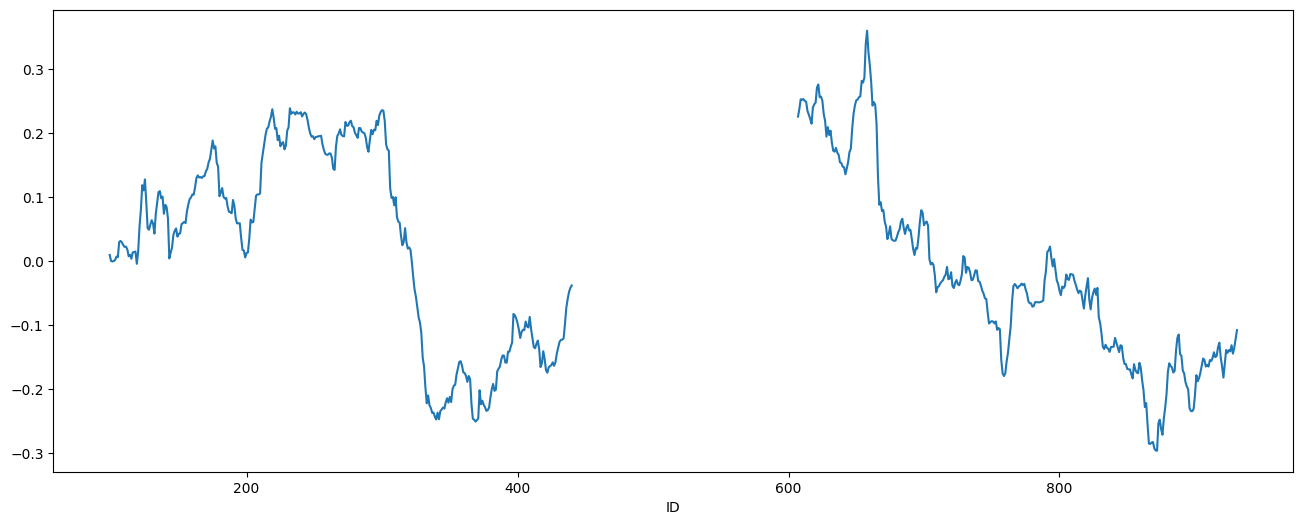

In [5]:
fig, ax = plt.subplots(figsize=(16, 6))
full_de['DE_RAIN'].rolling(window=100).mean().plot()

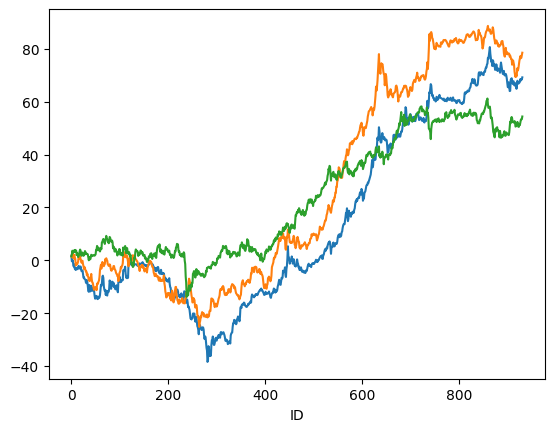

In [6]:
de_prices = pd.DataFrame(index=full_de.index)
for asset in ['CARBON', 'GAS', 'COAL']:
    de_prices[f'{asset}_PRICE'] = np.cumsum(full_de[f'{asset}_RET'])
    de_prices[f'{asset}_PRICE'].plot()

In [7]:
full_de.index.size

932

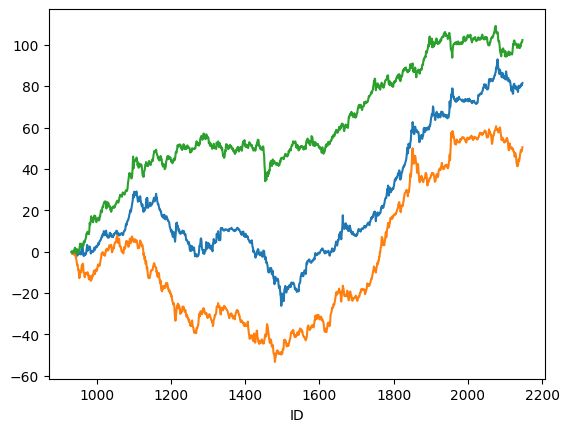

In [8]:
fr_prices = pd.DataFrame(index=full_fr.index)
for asset in ['CARBON', 'GAS', 'COAL']:
    fr_prices[f'{asset}_PRICE'] = np.cumsum(full_fr[f'{asset}_RET'])
    fr_prices[f'{asset}_PRICE'].plot()

DE_RAIN


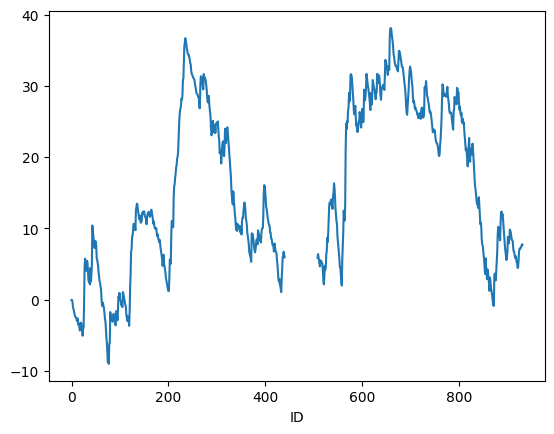

DE_WIND


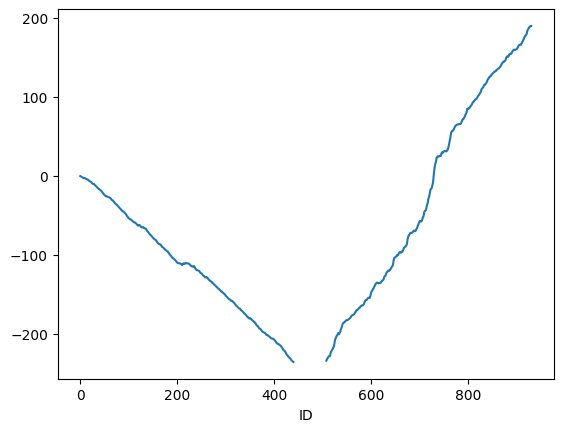

DE_TEMP


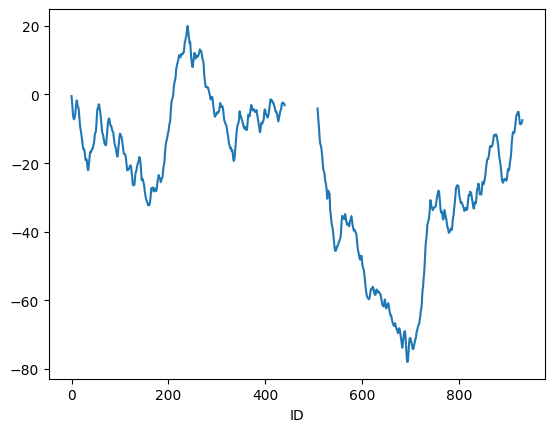

FR_RAIN


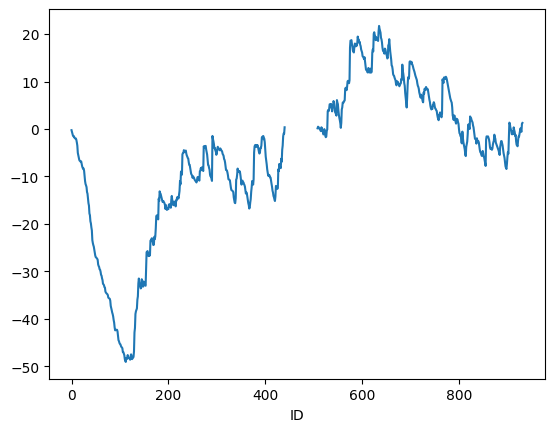

FR_WIND


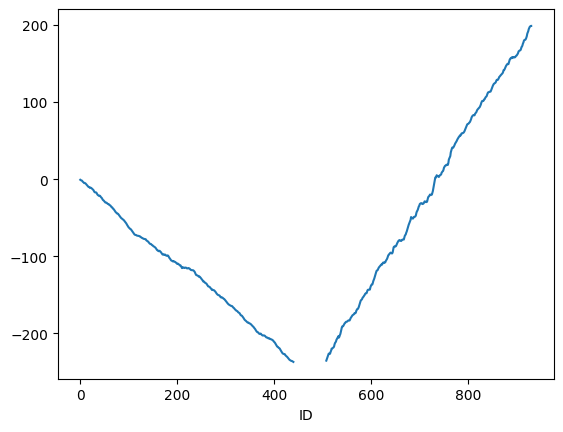

FR_TEMP


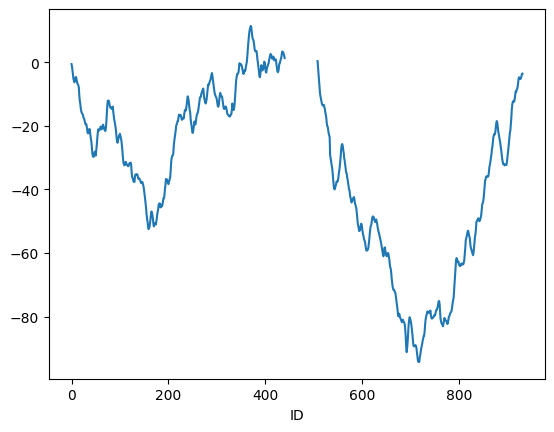

In [9]:
de_weathers = pd.DataFrame(index=full_de.index)
for w in weather_vars:
    print(w)
    de_prices[f'{w}_CUM'] = np.cumsum(full_de[w])
    de_prices[f'{w}_CUM'].plot()
    plt.show()

In [10]:
fr_prices

,CARBON_PRICE,GAS_PRICE,COAL_PRICE
ID,,,
932,-0.235452,-0.509720,0.100740
933,-0.456282,-0.865016,-0.200708
934,-1.007483,-0.547695,-0.150079
935,-0.737124,-0.468699,-0.756851
936,0.050029,-0.705438,-0.140573
...,...,...,...
2143,80.845762,49.180372,99.967810
2144,80.300155,48.395782,101.014262
2145,80.841839,48.545123,101.265706


In [11]:
de_prices

,CARBON_PRICE,GAS_PRICE,COAL_PRICE,DE_RAIN_CUM,DE_WIND_CUM,DE_TEMP_CUM,FR_RAIN_CUM,FR_WIND_CUM,FR_TEMP_CUM
ID,,,,,,,,,
0,1.790950,1.602466,1.527066,-0.047033,-0.370706,-0.466573,-0.248052,-0.844921,-0.558732
1,-0.370390,1.200772,2.246007,-0.047792,-0.756640,-1.928348,-0.644416,-1.369854,-1.328260
2,0.223006,2.797038,3.655241,-0.322693,-1.005312,-3.745770,-0.991589,-1.504900,-2.491559
3,-0.090355,2.969660,2.807696,-0.994715,-1.414794,-5.916449,-1.412803,-1.741577,-3.890982
4,-1.938058,1.018462,3.081553,-1.295598,-1.859205,-6.711839,-1.561395,-2.363773,-5.243868
...,...,...,...,...,...,...,...,...,...
927,68.588061,77.268848,52.112933,7.194682,188.132258,-8.698827,0.135974,196.172145,-5.259478
928,68.042454,76.484259,53.159385,7.407751,188.733428,-8.651677,-0.306112,197.611836,-4.895389
929,68.584138,76.633599,53.410829,7.453223,188.912981,-8.311577,-0.591937,198.135281,-4.414359


<Axes: xlabel='ID', ylabel='DE_TEMP'>

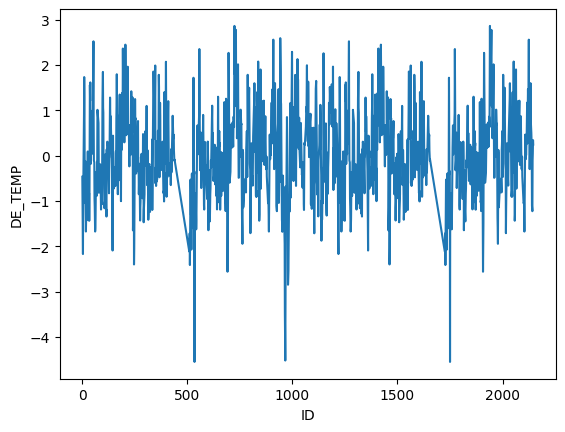

In [12]:
sns.lineplot(x=df.index, y=df['DE_TEMP'])

<Axes: xlabel='ID', ylabel='DE_WIND'>

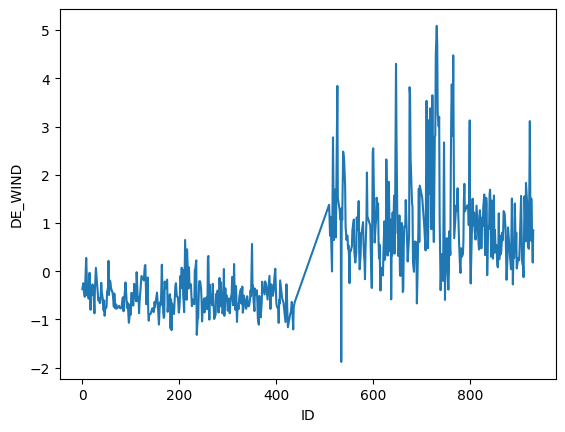

In [13]:
sns.lineplot(x=de.index, y=de['DE_WIND'])

<Axes: xlabel='ID', ylabel='DE_WIND'>

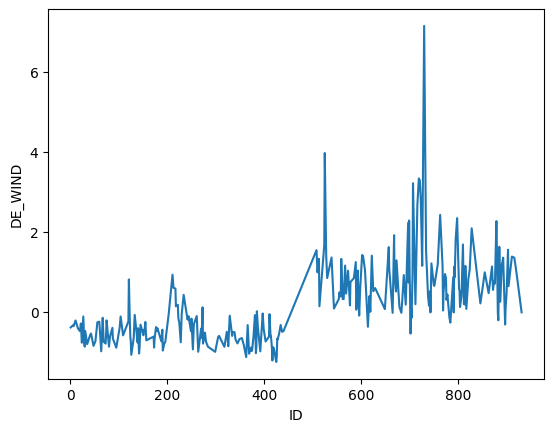

In [14]:
sns.lineplot(x=true_test[true_test['COUNTRY'] == 'DE'].index, y=true_test[true_test['COUNTRY'] == 'DE']['DE_WIND'])

<Figure size 640x480 with 0 Axes>

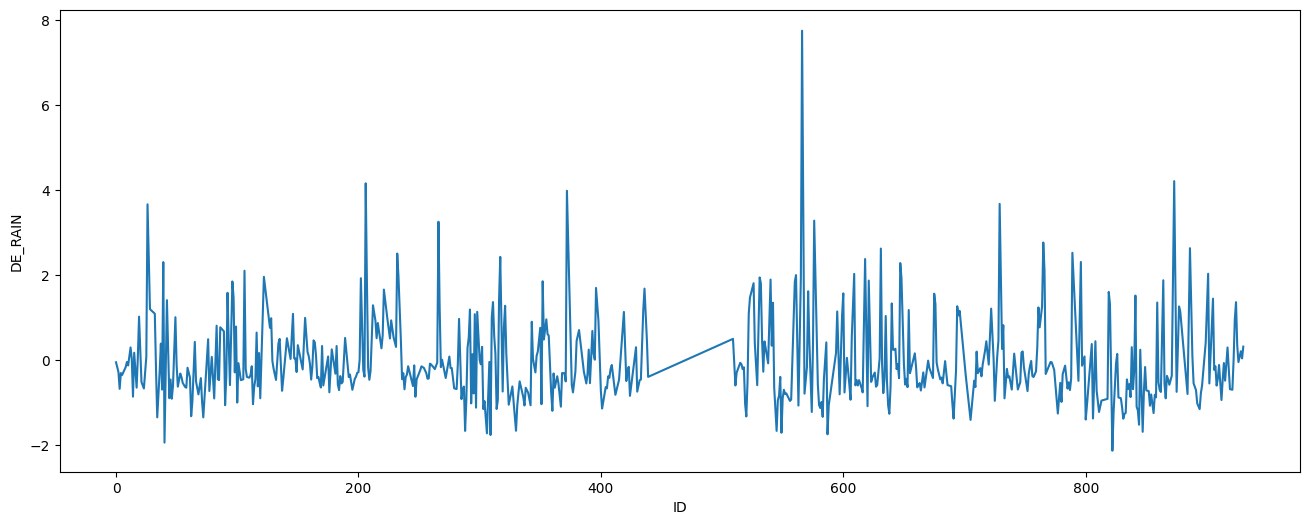

<Figure size 640x480 with 0 Axes>

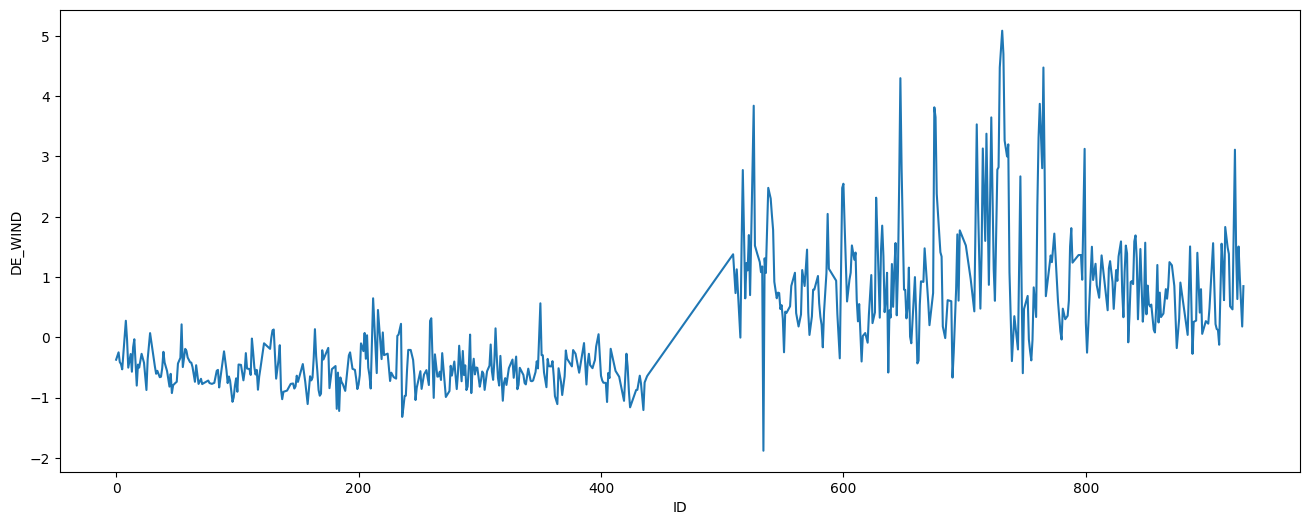

<Figure size 640x480 with 0 Axes>

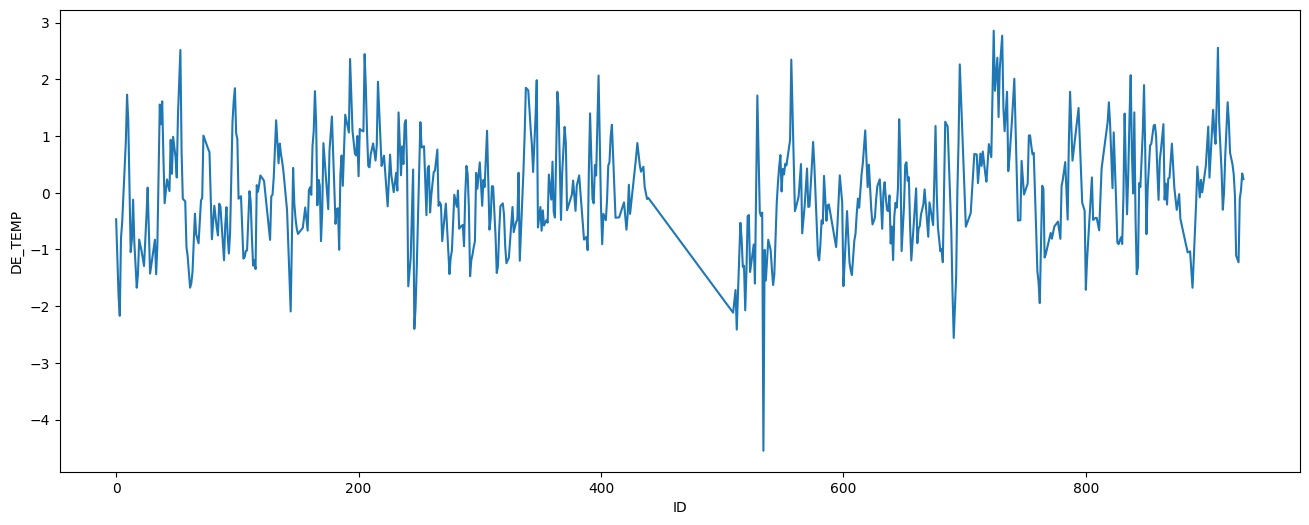

In [15]:
temp_de = de.copy()
temp_de['TARGET'] = y_de['TARGET']
for w in ['RAIN', 'WIND', 'TEMP']:
    plt.figure()
    fig, ax = plt.subplots(figsize=(16, 6))
    sns.lineplot(x=temp_de.index, y=temp_de[f'DE_{w}'])

### 24 Hour Rain Forecasting

In [12]:
country_rain = 'DE_WIND'
df_rain = full_de[country_rain].copy()

# make all rain positive for gamma regressor
de_rain_offset = abs(df_rain.min()) + 1
df_rain = df_rain + de_rain_offset

# fourier_52 = Fourier(period=50.6, order=1)
fourier_25 = Fourier(period=25, order=3)

# [25.1, 138.2, 194.7, 351.9, 408.4]
extra_fourier = [Fourier(period=i, order=3) for i in [365.25]]

dp = DeterministicProcess(
    constant=True,
    period=52,
    index=df_rain.index,
    order=1,
    fourier=3,
    additional_terms=extra_fourier
)
x_fit = dp.in_sample().loc[:439]
y_fit = df_rain.loc[:439]
ridge = linear_model.Ridge(alpha=3)
ridge.fit(x_fit, y_fit)
y_deseasoned = y_fit - ridge.predict(x_fit)
# plt.clf()
# fig, ax = plt.subplots(2)
# ax[0].set_ylabel('DE_RAIN'), ax[1].set_ylabel('DE_RAIN')
# sns.lineplot(x=x_fit.index, y=y_deseasoned, ax=ax[0])
# sns.lineplot(x=x_fit.index, y=y_fit, ax=ax[1])

In [13]:
x_train = dp.in_sample().loc[:439]
y_train = df_rain.loc[:439]
y_train = y_train - y_train.min() + 0.01
for i in range(1, 6):
    x_train[f'LAG_{i}'] = y_train.shift(i).fillna(y_train.mean())
# x_test['LAG_1'] = y_test.shift(1).fillna(y_test.mean())
de_rain_fit = full_de.loc[:439].drop(['DAY_ID', 'COUNTRY'] + weather_vars, axis=1)
x_train = pd.concat([de_rain_fit, x_train], axis=1)
# x_train = lag_shift(x_train, [1])

In [14]:
tss = TimeSeriesSplit(n_splits=5, max_train_size=None, test_size=67)

#### Generalized Linear Model (Gamma Distribution)
Turns out 24 hour rainfall is best modeled by a gamma distribution (as verified below with a KS test)

mape test: 0.41831625926443433
mape train: 0.1499889918652234


<Figure size 640x480 with 0 Axes>

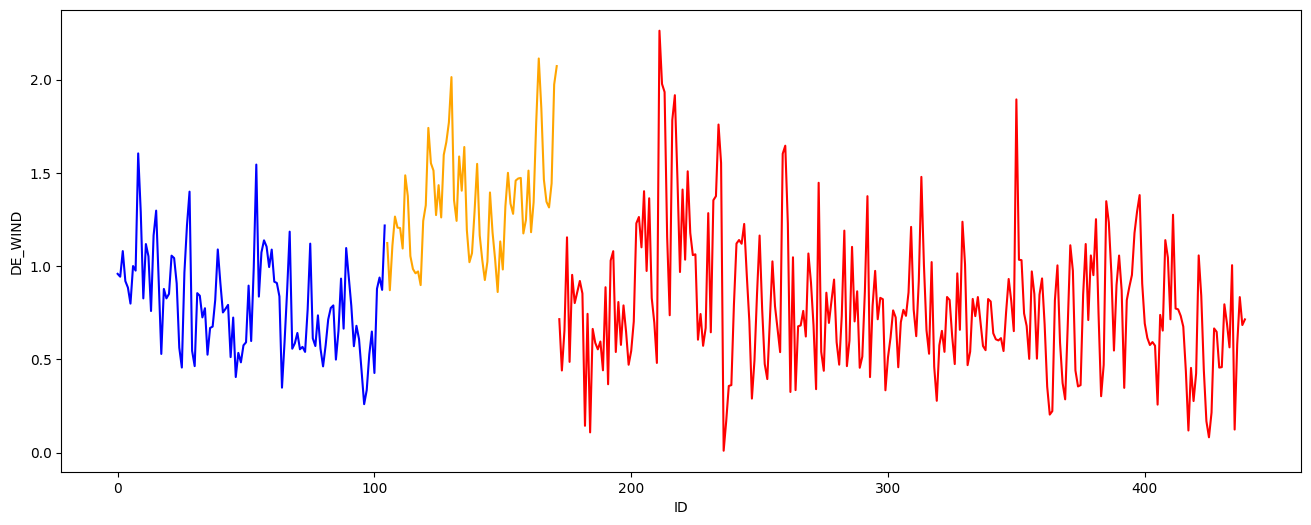

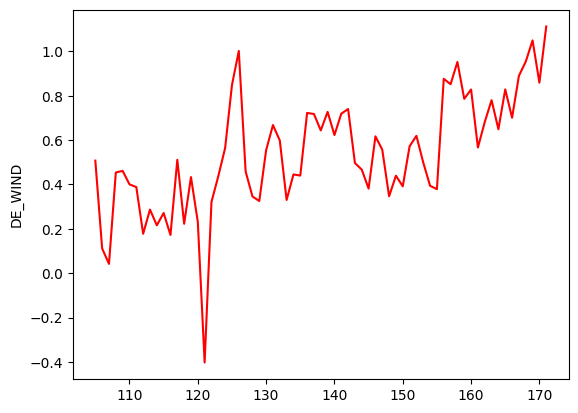

mape test: 0.29247926694430043
mape train: 0.16647435924660012


<Figure size 640x480 with 0 Axes>

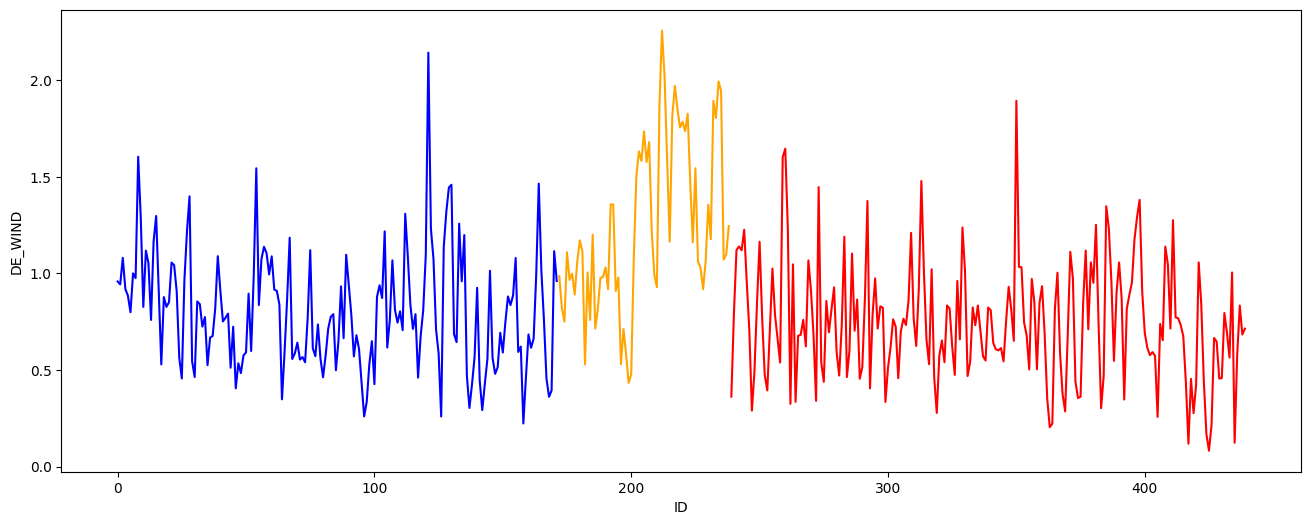

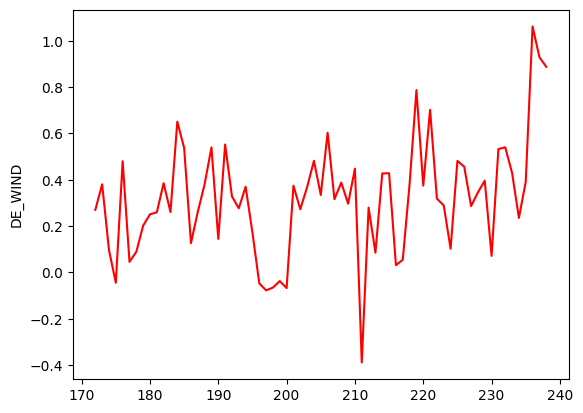

mape test: 0.24835112384750485
mape train: 0.17906488496547773


<Figure size 640x480 with 0 Axes>

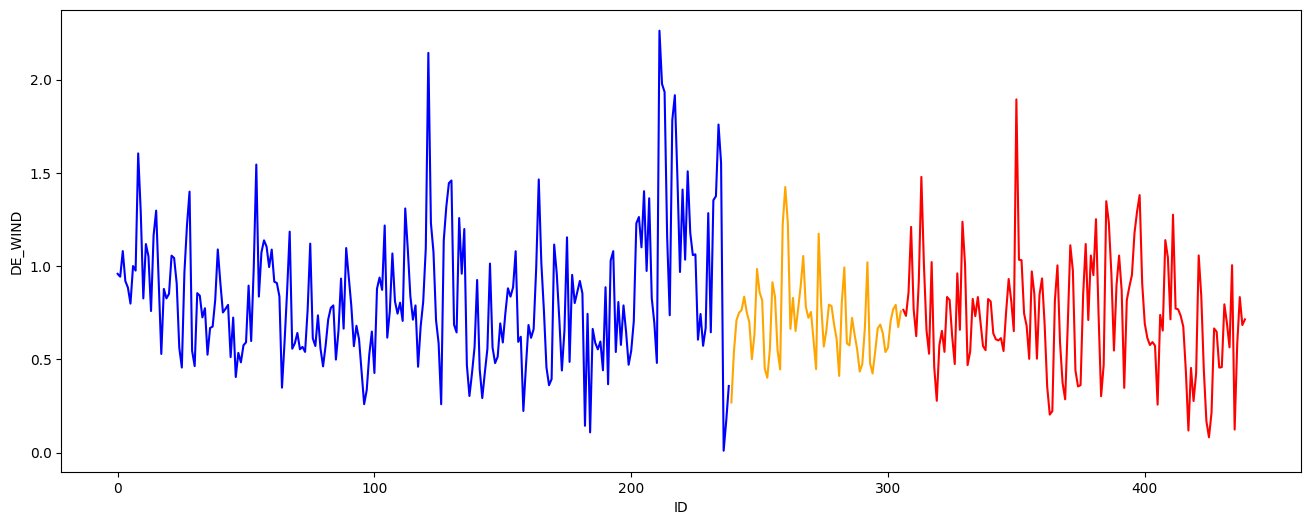

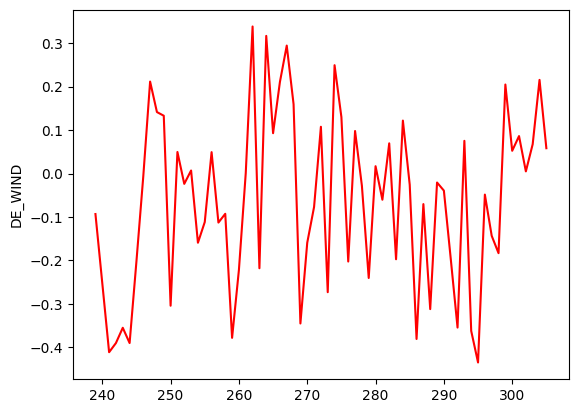

mape test: 0.34854899341547596
mape train: 0.1858950231022407


<Figure size 640x480 with 0 Axes>

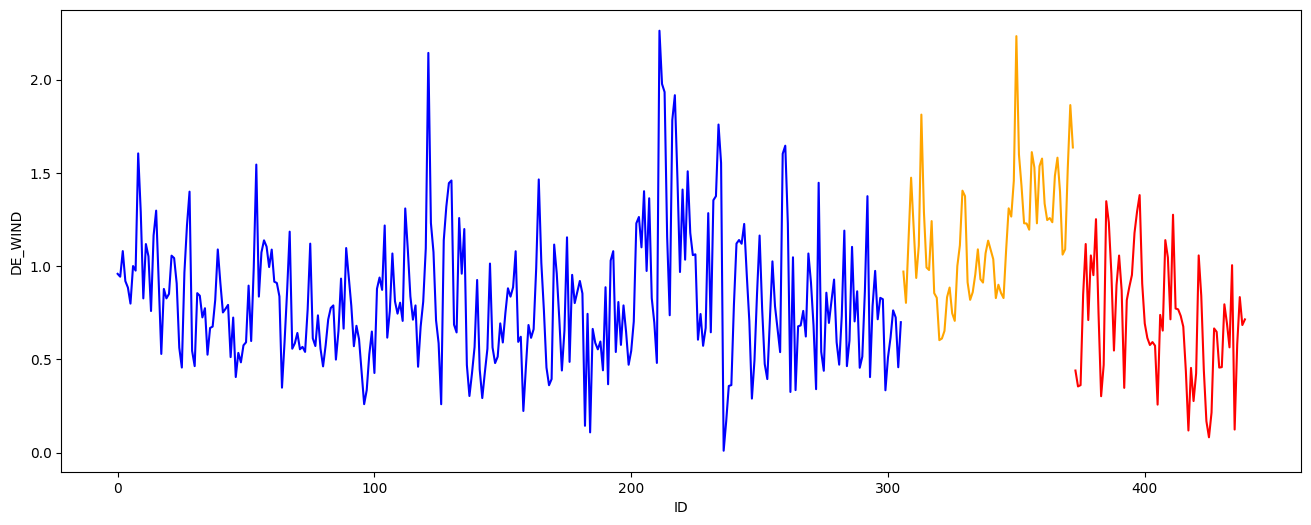

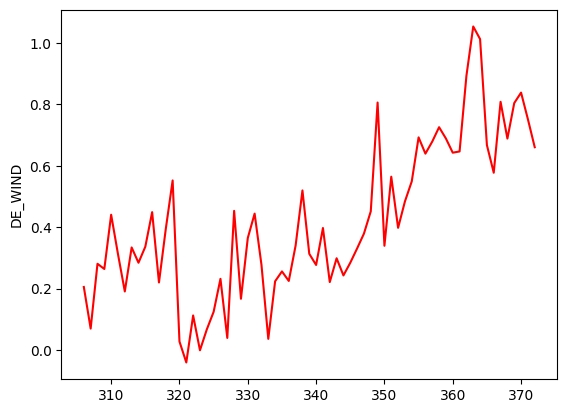

mape test: 0.3882083943462961
mape train: 0.19160287657166697


<Figure size 640x480 with 0 Axes>

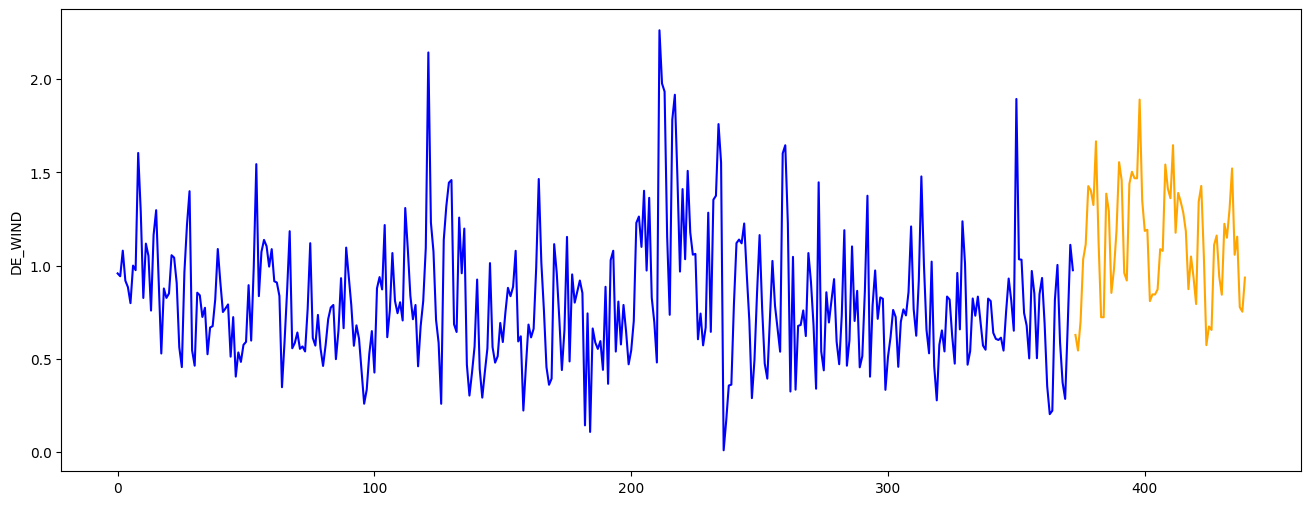

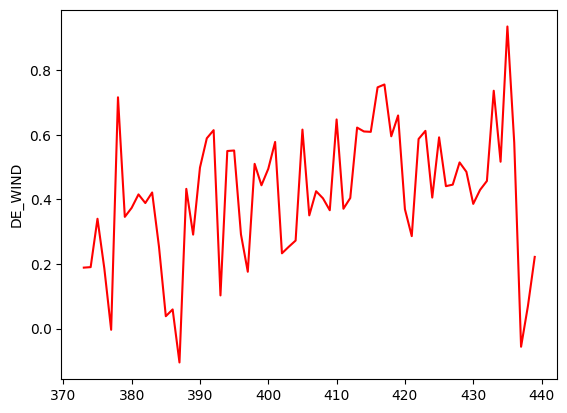

In [15]:
ridge = linear_model.Ridge(alpha=10, fit_intercept=False)
tss = TimeSeriesSplit(n_splits=5, max_train_size=None, test_size=67)
time_series_test(tss, ridge, x_train, y_train, wind_excess=False, graph_residuals=True, method='mape')

mape test: 0.22051089155023124
mape train: 0.15023928705557435


<Figure size 640x480 with 0 Axes>

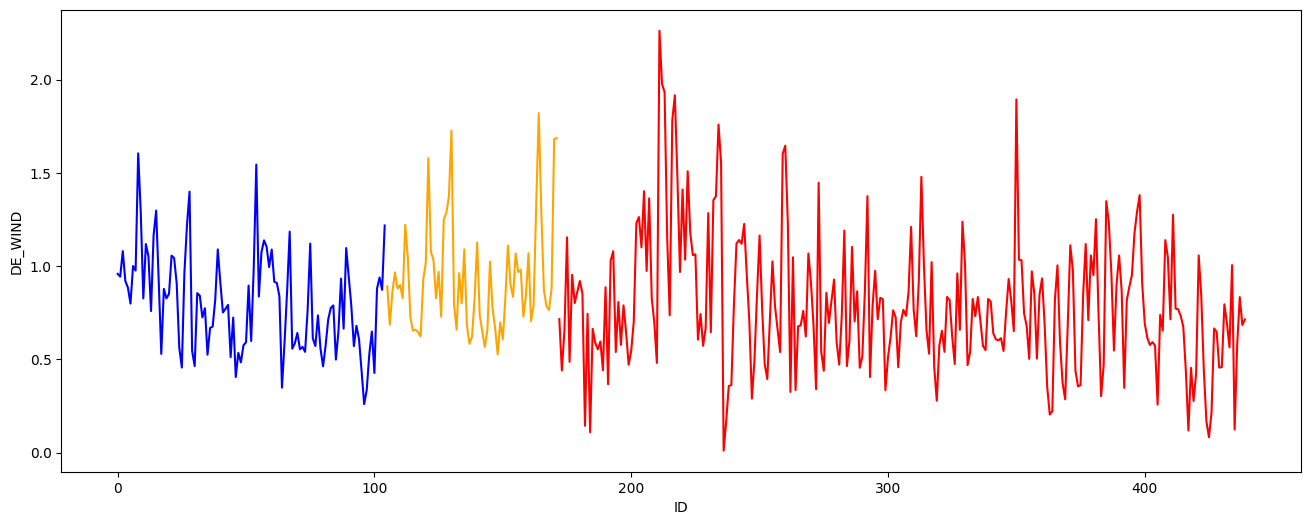

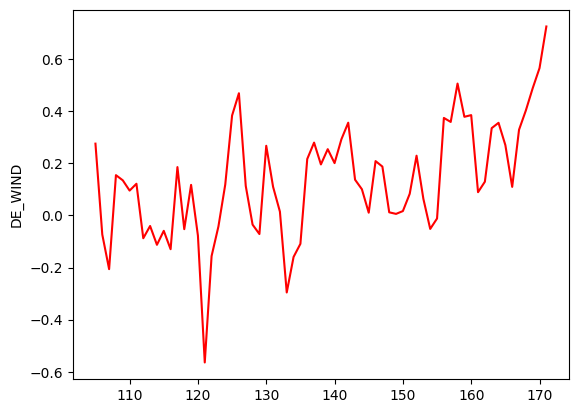

mape test: 0.3120244706360951
mape train: 0.16254455996554046


<Figure size 640x480 with 0 Axes>

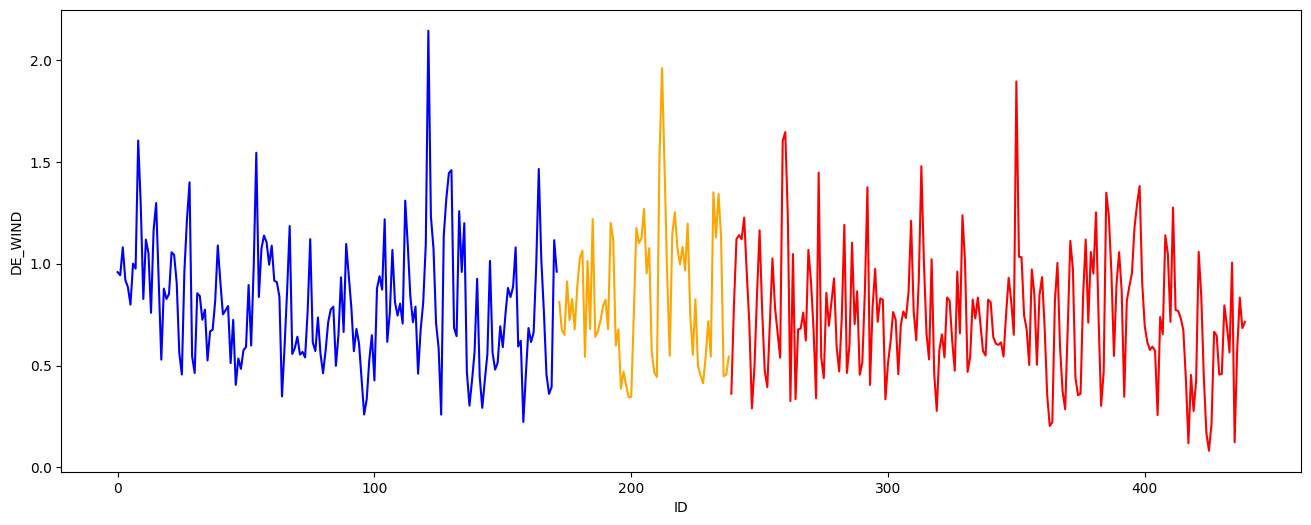

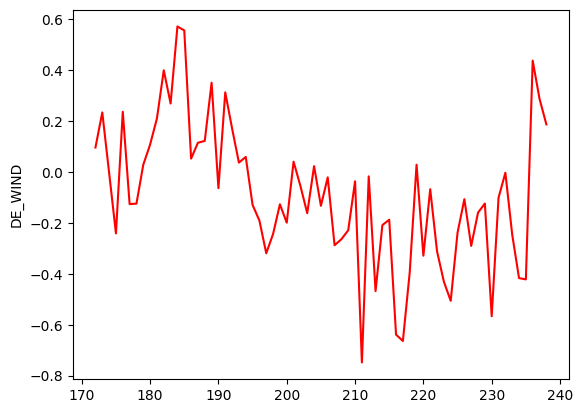

mape test: 0.826240832139098
mape train: 0.17976270439046924


<Figure size 640x480 with 0 Axes>

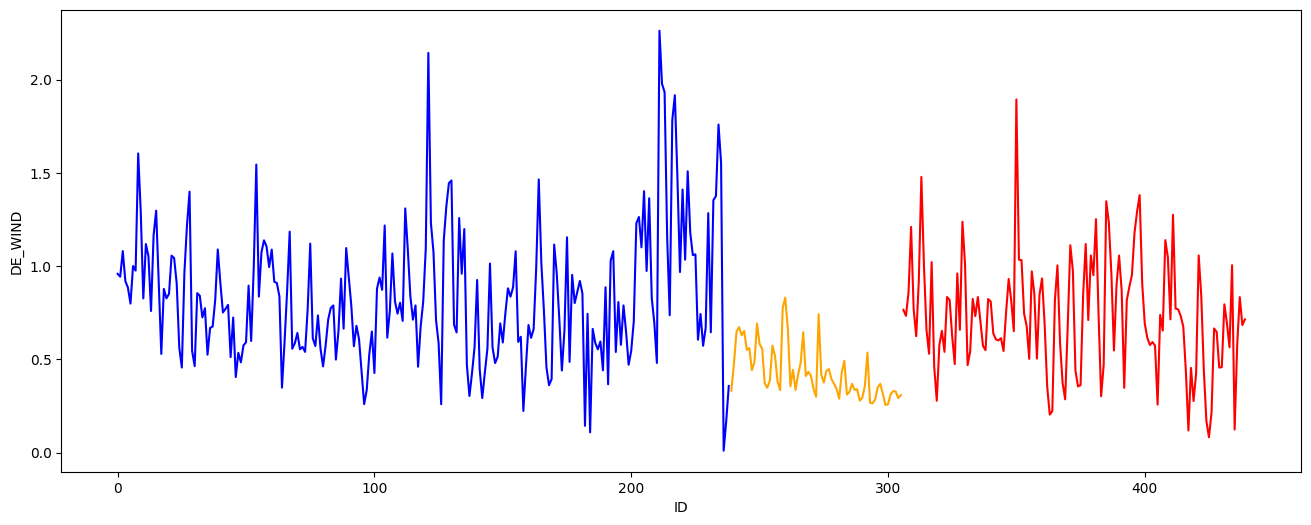

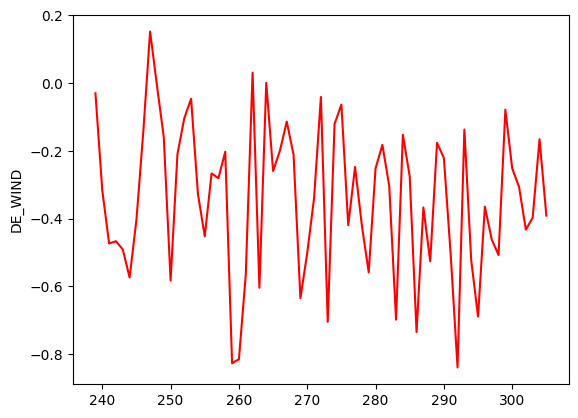

mape test: 0.24787562887371742
mape train: 0.18947173115836727


<Figure size 640x480 with 0 Axes>

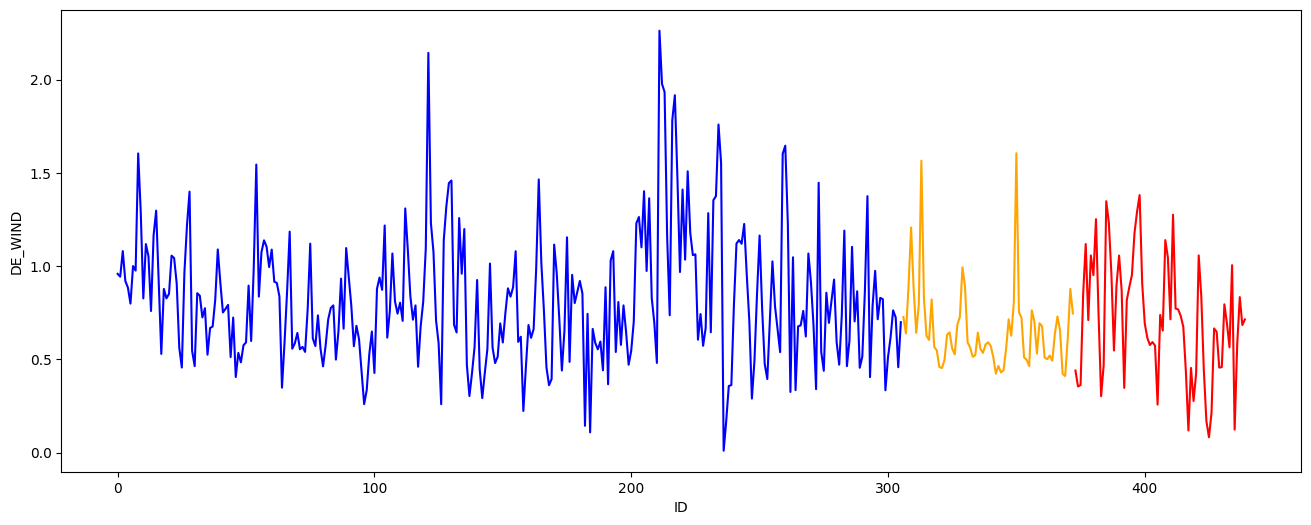

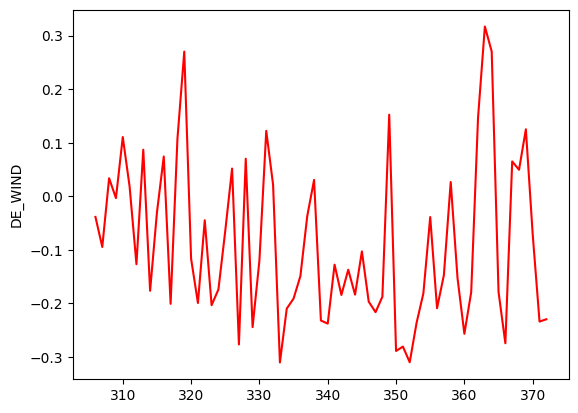

mape test: 0.3587247627145871
mape train: 0.32396628462168175


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:46: RuntimeWarning: invalid value encountered in matmul
  devp = temp @ X  # same as X.T @ temp


<Figure size 640x480 with 0 Axes>

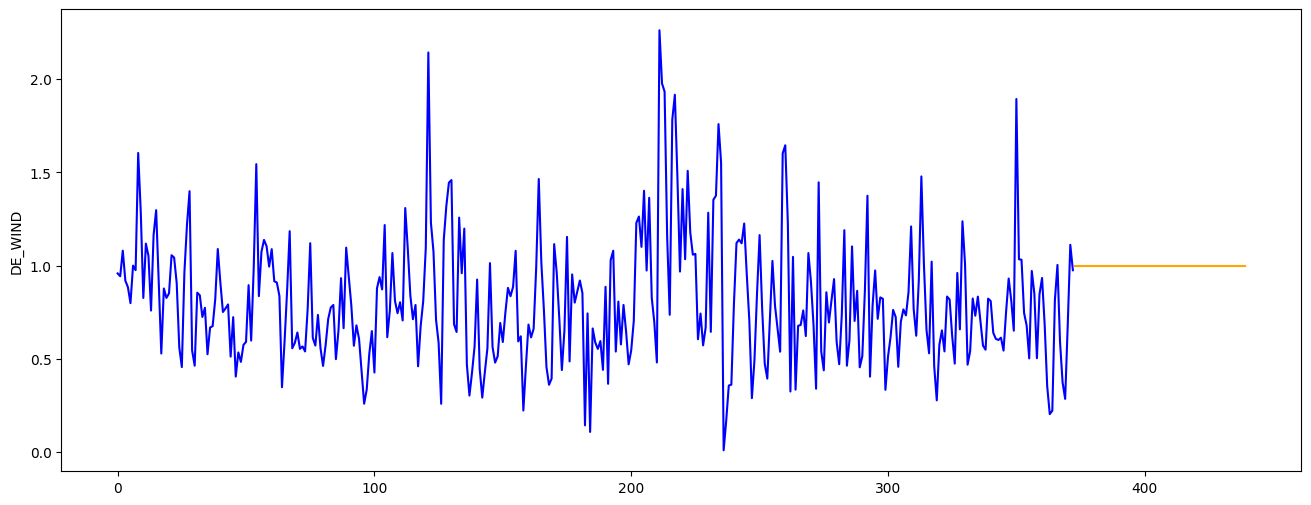

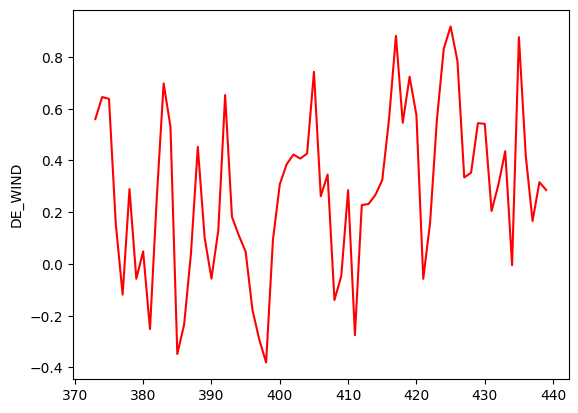

In [20]:
gg = linear_model.GammaRegressor(alpha=0.2, fit_intercept=False)
tss = TimeSeriesSplit(n_splits=5, max_train_size=None, test_size=67)
time_series_test(tss, gg, x_train, y_train, wind_excess=False, graph_residuals=True, method='mape')

mape test: 0.28124241694642005
mape train: 0.13905291230492076


<Figure size 640x480 with 0 Axes>

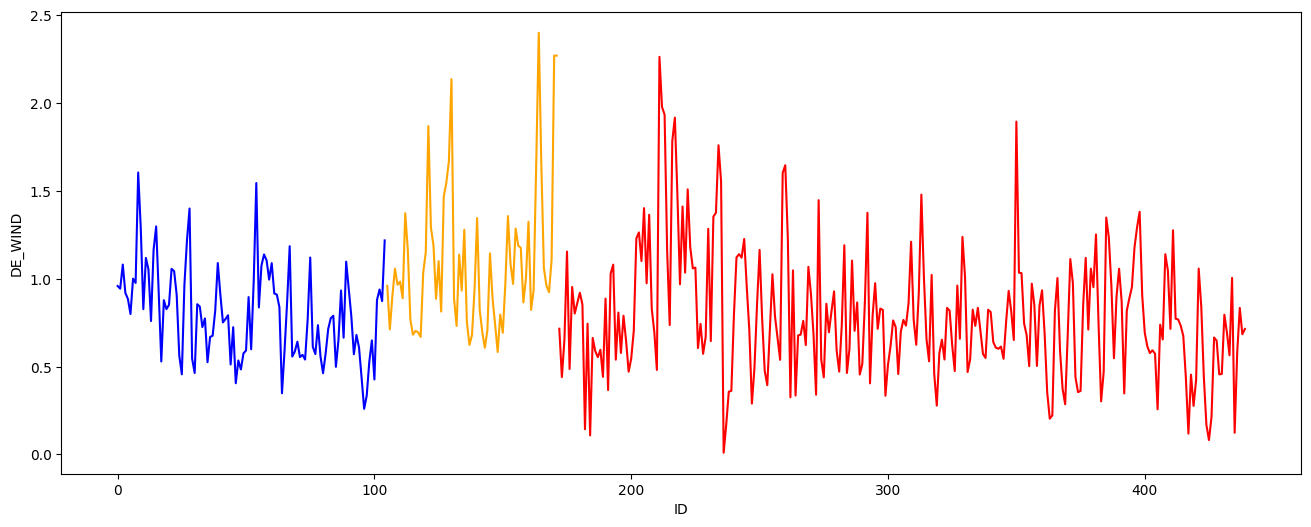

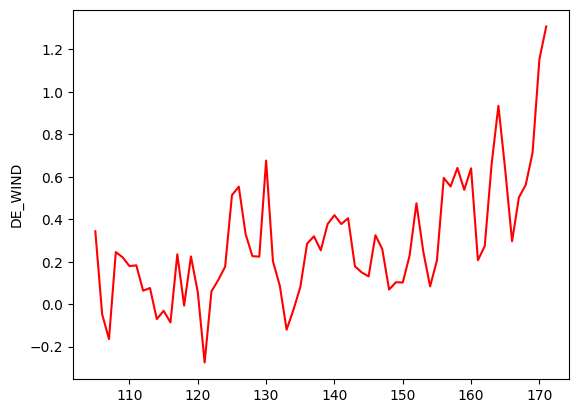

mape test: 0.29845933210825343
mape train: 0.15756182229905066


<Figure size 640x480 with 0 Axes>

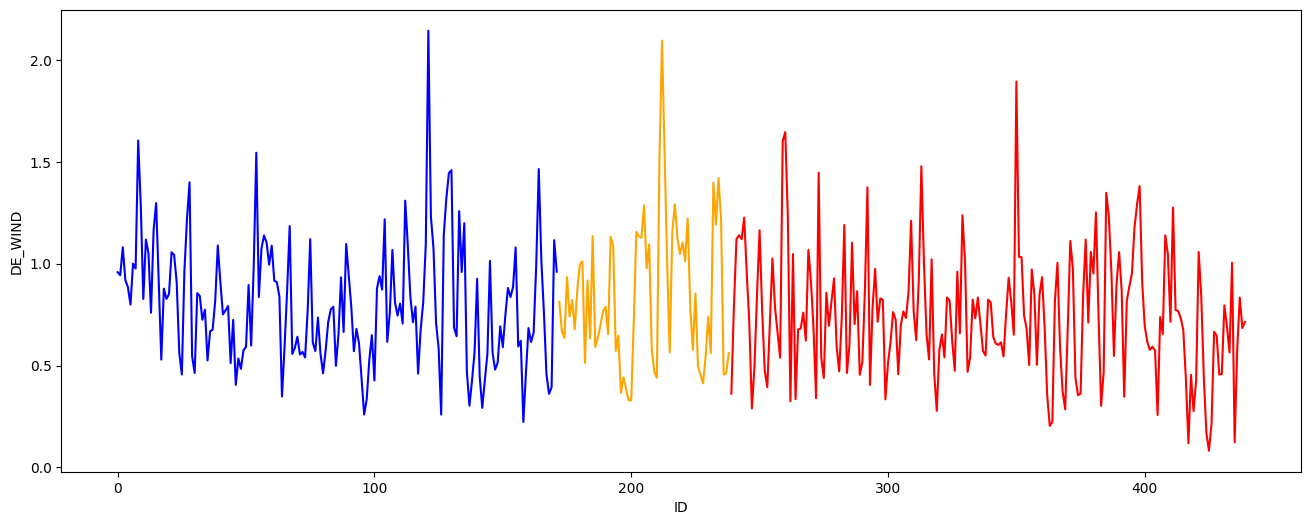

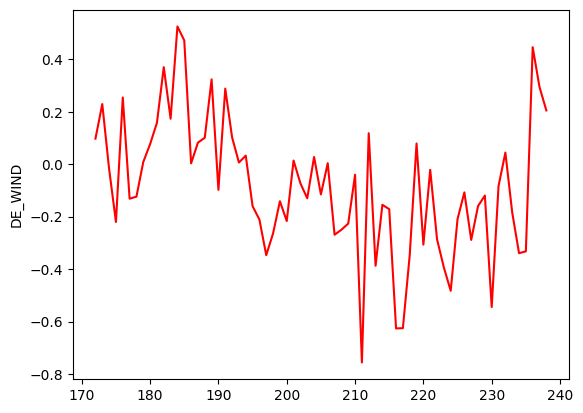

mape test: 0.7008394223006326
mape train: 0.17089912003220345


<Figure size 640x480 with 0 Axes>

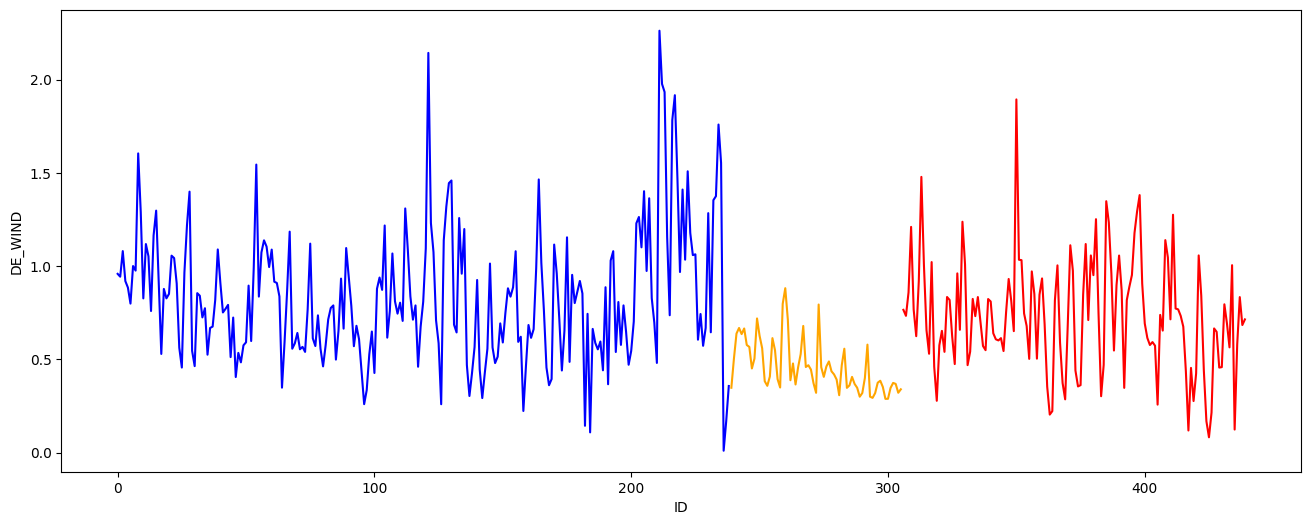

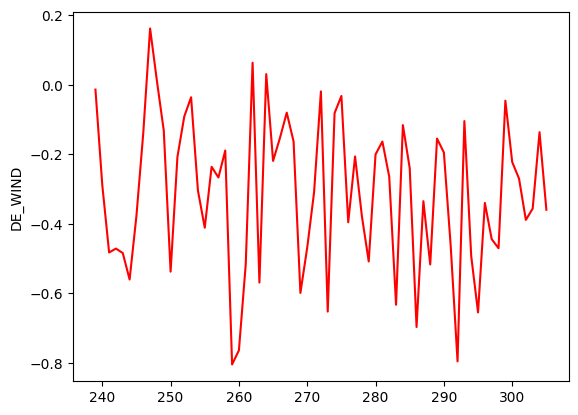

mape test: 0.1905881888943216
mape train: 0.18188714183036994


<Figure size 640x480 with 0 Axes>

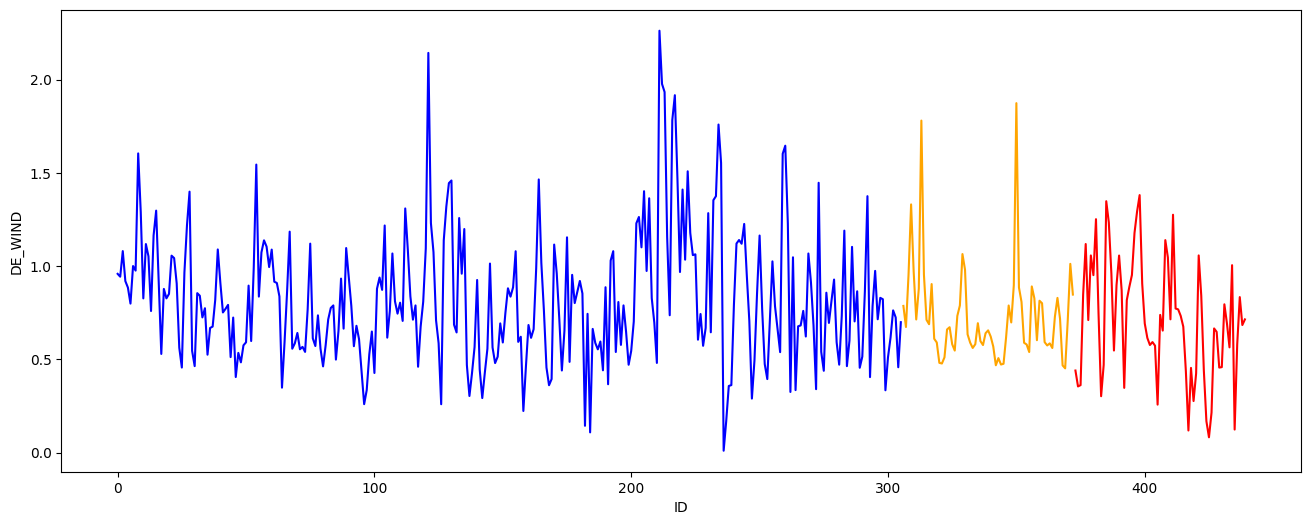

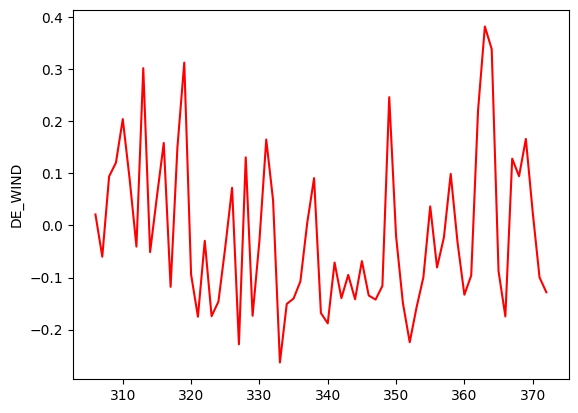

mape test: 0.23367571781817537
mape train: 0.18030462824846993


<Figure size 640x480 with 0 Axes>

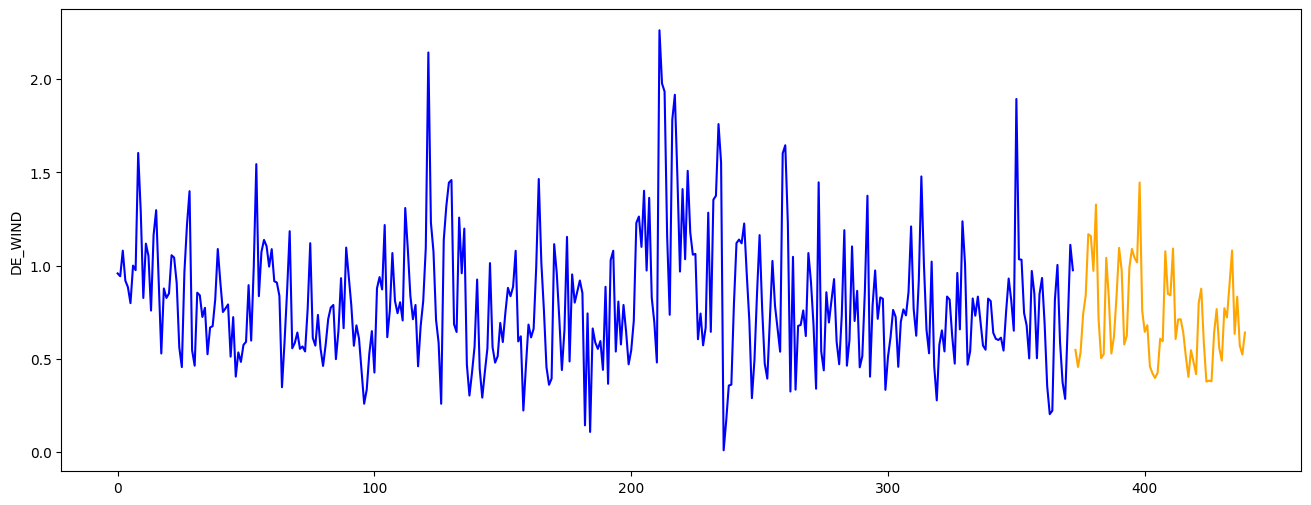

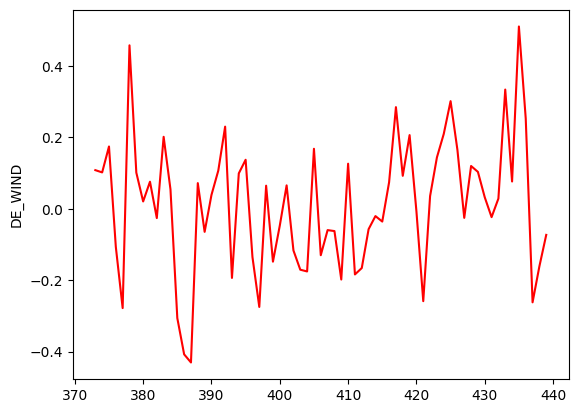

In [18]:
twd = linear_model.TweedieRegressor(power=1.5, alpha=0.1, fit_intercept=True)
tss = TimeSeriesSplit(n_splits=5, max_train_size=None, test_size=67)
time_series_test(tss, twd, x_train, y_train, wind_excess=False, graph_residuals=True, method='mape')

In [22]:
pd.DataFrame(data=xgb_model.feature_importances_, index=x_train.columns).sort_values(0, ascending=False)

NameError: name 'xgb_model' is not defined

In [ ]:
fs = np.linspace(0.1, 500, 1000)
plt.figure()
    
pgram = signal.lombscargle(x=x_train.index, y=train_output, freqs=fs)
print([fs[i] for i in np.argwhere(pgram > 25).ravel()])
p_de = sns.lineplot(x=fs, y=pgram)
p_de.set(xlabel='train')

plt.show()
plt.figure()

pgram = signal.lombscargle(x=x_test.index, y=test_output, freqs=fs)
print([fs[i] for i in np.argwhere(pgram > 25).ravel()])
p_de = sns.lineplot(x=fs, y=pgram)
p_de.set(xlabel='test')

plt.show()

In [ ]:
gg = linear_model.GammaRegressor(alpha=0.2)
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, gamma=5)
train_output, test_output = test_model(gg, x_train, x_test, y_train, y_test, model_1=xgb_model, detailed=True, graph_residuals=True, method='mape')

In [ ]:
gg = linear_model.GammaRegressor(alpha=0.2)
kf = KFold(n_splits = 5)
kf_test_model(kf, gg, x_train, y_train, wind_excess=False, target_col=None, graph_residuals=True, method='mape')

In [ ]:
plt.clf()
fig, ax = plt.subplots(2)
print(mape(y_train, gg.predict(x_train)))
print(mape(y_test, gg.predict(x_test)))
sns.lineplot(x=y_train.index, y=y_train, ax=ax[0])
sns.lineplot(x=y_train.index, y=gg.predict(x_train), ax=ax[0])
sns.lineplot(x=y_test.index, y=y_test, ax=ax[1])
sns.lineplot(x=y_test.index, y=gg.predict(x_test), ax=ax[1])

In [ ]:
de

In [ ]:
cols = pd.DataFrame(de.drop(['COUNTRY'], axis=1).columns)
for w in ['RAIN', 'WIND', 'TEMP']:
    cols[f'MI_FR_{w}'] = mir(X=de.drop(['COUNTRY'], axis=1).dropna(), y=de[f'FR_{w}'].dropna())
cols

In [ ]:
fs = np.linspace(0.1, 500, 1000)
for col in weather_vars:
    plt.figure()
    fig, axs = plt.subplots(2)
    
    pgram = signal.lombscargle(x=fr[col].dropna().index, y=fr[col].dropna(), freqs=fs)
    print([fs[i] for i in np.argwhere(pgram > 5).ravel()])
    p_fr = sns.lineplot(x=fs, y=pgram, ax=axs[0])
    p_fr.set(xlabel=f'{col} for FR')
    
    pgram = signal.lombscargle(x=de[col].dropna().index, y=de[col].dropna(), freqs=fs)
    print([fs[i] for i in np.argwhere(pgram > 5).ravel()])
    p_de = sns.lineplot(x=fs, y=pgram, ax=axs[1])
    p_de.set(xlabel=f'{col} for DE')
    
    plt.show()

In [ ]:
de.count()

In [ ]:
df_weather = country_flow(fourier_features(de)).drop(['DAY_ID', 'COUNTRY'], axis=1)

weather_train = df_weather[df_weather['DE_RAIN'].notna()]
weather_test = df_weather[df_weather['DE_RAIN'].isna()]

y = weather_train[['DE_WIND', 'DE_RAIN', 'DE_TEMP', 'FR_WIND', 'FR_RAIN', 'FR_TEMP']]
weather_train = weather_train.drop(['DE_WIND', 'DE_RAIN', 'DE_TEMP', 'FR_WIND', 'FR_RAIN', 'FR_TEMP'], axis=1)
weather_test = weather_test.drop(['DE_WIND', 'DE_RAIN', 'DE_TEMP', 'FR_WIND', 'FR_RAIN', 'FR_TEMP'], axis=1)

### Feature Engineering

In [ ]:
y

### Models

In [ ]:
x = lag_shift(weather_train, np.arange(3))
target = y
curr = 'FR_TEMP'
# de: ridge alpha 40, xgb gamma 25

In [ ]:
weather_train

In [ ]:
# x = (x - x.mean()) / x.std()

In [ ]:
# perform train test split after features have been calculated
x_train, x_test, y_train, y_test = train_test_split(x, target[curr], test_size=0.33, random_state=88, shuffle=False)

#### Baseline Linear Regression

In [ ]:
lr = LinearRegression()
train_result, test_result = test_model(lr, x_train, x_test, y_train, y_test)

#### Ridge Regression

In [ ]:
ridge = linear_model.Ridge(alpha=0.1)
train_result, test_result = test_model(ridge, x_train, x_test, y_train, y_test, print_output=False, graph_residuals=False)

#### XGB Regression

In [ ]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, gamma=10)
train_result, test_result = test_model(xgb_model, x_train, x_test, y_train, y_test, print_output=False, graph_residuals=False)

In [ ]:
kf = KFold(n_splits = 5, shuffle=True)
kf_test_model(kf, xgb_model, x, target, wind_excess=False, target_col=curr)

#### Ridge Regression - XGB Hybrid

In [ ]:
ridge = linear_model.Ridge(alpha=0.1)
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, gamma=6.8)
train_result, test_result = test_model(ridge, x_train, x_test, y_train, y_test, model_1=xgb_model, detailed=True, print_output=False, graph_residuals=True)

### Output

In [ ]:
weather_forecast = full_de[full_de['DE_WIND'].isna()][weather_vars]

#### RAIN

In [ ]:
# FR, LAG 5 (to be tuned)
twd = linear_model.TweedieRegressor(power=2.7, alpha=0.08, fit_intercept=True)
tss = TimeSeriesSplit(n_splits=5, max_train_size=None, test_size=67)
time_series_test(tss, twd, x_train, y_train, wind_excess=False, graph_residuals=True, method='mape')

In [ ]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, gamma=3)
xgb_model.fit(weather_train, y['DE_WIND'])
weather_forecast['DE_WIND'] = xgb_model.predict(weather_test)

In [ ]:
pd.DataFrame(data=xgb_model.feature_importances_, index=weather_train.columns).sort_values(0, ascending=False)

#### TEMP

In [ ]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, gamma=0.5)
xgb_model.fit(weather_train, y['FR_WIND'])
weather_forecast['FR_WIND'] = xgb_model.predict(weather_test)

In [ ]:
weather_forecast

#### DirRec Testing

In [23]:
pd.concat([full_de, lag_shift(full_de[weather_vars], range(1, 6), only_shifts=True)], axis=1)

,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,DE_RAIN_SHIFT_1,DE_WIND_SHIFT_1,DE_TEMP_SHIFT_1,FR_RAIN_SHIFT_1,FR_WIND_SHIFT_1,FR_TEMP_SHIFT_1,DE_RAIN_SHIFT_2,DE_WIND_SHIFT_2,DE_TEMP_SHIFT_2,FR_RAIN_SHIFT_2,FR_WIND_SHIFT_2,FR_TEMP_SHIFT_2,DE_RAIN_SHIFT_3,DE_WIND_SHIFT_3,DE_TEMP_SHIFT_3,FR_RAIN_SHIFT_3,FR_WIND_SHIFT_3,FR_TEMP_SHIFT_3,DE_RAIN_SHIFT_4,DE_WIND_SHIFT_4,DE_TEMP_SHIFT_4,FR_RAIN_SHIFT_4,FR_WIND_SHIFT_4,FR_TEMP_SHIFT_4,DE_RAIN_SHIFT_5,DE_WIND_SHIFT_5,DE_TEMP_SHIFT_5,FR_RAIN_SHIFT_5,FR_WIND_SHIFT_5,FR_TEMP_SHIFT_5
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1190,DE,0.583923,0.276131,0.778353,-0.778353,0.931374,-0.188162,-0.931374,0.188162,0.836731,0.048137,0.200623,-0.777195,0.076310,-0.664384,0.780177,0.661807,0.390828,0.598856,-0.012385,-0.970238,0.625910,0.293219,0.448995,-0.047033,-0.248052,-0.370706,-0.844921,-0.466573,-0.558732,1.602466,1.527066,1.790950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1072,DE,0.599993,0.320804,0.141289,-0.141289,0.694028,0.074866,-0.694028,-0.074866,0.959734,-0.144798,-0.096841,-0.428909,-0.602358,-0.771224,0.804110,0.510648,0.500201,0.284886,0.066511,0.124200,0.790924,0.200128,0.277952,-0.000759,-0.396363,-0.385935,-0.524933,-1.461775,-0.769528,-0.401694,0.718941,-2.161340,-0.047033,-0.370706,-0.466573,-0.248052,-0.844921,-0.558732,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,38,DE,0.548187,0.343348,-0.179177,0.179177,0.588670,0.395241,-0.588670,-0.395241,1.062806,-0.149029,0.292958,-0.433503,-0.487960,-0.651284,0.832773,0.487943,0.447086,0.374206,-0.329384,0.763672,0.722983,0.529501,0.151134,-0.274901,-0.347173,-0.248671,-0.135046,-1.817422,-1.163299,1.596267,1.409234,0.593396,-0.000759,-0.385935,-1.461775,-0.396363,-0.524933,-0.769528,-0.047033,-0.370706,-0.466573,-0.248052,-0.844921,-0.558732,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,872,DE,0.470907,0.346433,-0.707035,0.707035,0.111881,0.536853,-0.111881,-0.536853,1.223117,0.751191,0.150620,-0.780338,0.044238,-0.780774,0.842046,0.325375,-0.053067,1.317438,-0.446433,0.313770,0.707787,0.738900,0.187547,-0.672022,-0.421214,-0.409482,-0.236677,-2.170678,-1.399423,0.172622,-0.847545,-0.313360,-0.274901,-0.248671,-1.817422,-0.347173,-0.135046,-1.163299,-0.000759,-0.385935,-1.461775,-0.396363,-0.524933,-0.769528,-0.047033,-0.370706,-0.466573,-0.248052,-0.844921,-0.558732,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,933,DE,0.284447,0.356063,0.389806,-0.389806,1.506291,-0.035824,-1.506291,0.035824,0.202693,0.529175,-0.665840,-0.774925,-0.738709,-0.634913,0.126256,0.179647,1.431625,0.746898,0.465544,0.673174,0.500184,-0.656051,0.158859,-0.300883,-0.148592,-0.444411,-0.622197,-0.795390,-1.352885,-1.951199,0.273857,-1.847703,-0.672022,-0.409482,-2.170678,-0.421214,-0.236677,-1.399423,-0.274901,-0.248671,-1.817422,-0.347173,-0.135046,-1.163299,-0.000759,-0.385935,-1.461775,-0.396363,-0.524933,-0.769528,-0.047033,-0.370706,-0.466573,-0.248052,-0.844921,-0.558732,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [3]:
de_rain_model = linear_model.TweedieRegressor(power=1.5, alpha=0.1, fit_intercept=True)
de_wind_model = linear_model.TweedieRegressor(power=1.5, alpha=0.1, fit_intercept=True)
de_temp_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, gamma=0.5)
fr_rain_model = linear_model.TweedieRegressor(power=1.5, alpha=0.1, fit_intercept=True)
fr_wind_model = linear_model.TweedieRegressor(power=1.5, alpha=0.1, fit_intercept=True)
fr_temp_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, gamma=0.5)
X = fill_weather_gap(full_de, de_rain_model, de_wind_model, de_temp_model, fr_rain_model, fr_wind_model, fr_temp_model)

predicting row 441, column DE_TEMP...
predicting row 441, column FR_TEMP...
predicting row 441, column DE_RAIN...
predicting row 441, column FR_RAIN...
predicting row 441, column DE_WIND...
predicting row 441, column FR_WIND...
predicting row 442, column DE_TEMP...
predicting row 442, column FR_TEMP...
predicting row 442, column DE_RAIN...
predicting row 442, column FR_RAIN...
predicting row 442, column DE_WIND...
predicting row 442, column FR_WIND...
predicting row 443, column DE_TEMP...
predicting row 443, column FR_TEMP...
predicting row 443, column DE_RAIN...
predicting row 443, column FR_RAIN...
predicting row 443, column DE_WIND...
predicting row 443, column FR_WIND...
predicting row 444, column DE_TEMP...
predicting row 444, column FR_TEMP...
predicting row 444, column DE_RAIN...
predicting row 444, column FR_RAIN...
predicting row 444, column DE_WIND...
predicting row 444, column FR_WIND...
predicting row 445, column DE_TEMP...
predicting row 445, column FR_TEMP...
predicting r

/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)


predicting row 474, column FR_TEMP...
predicting row 474, column DE_RAIN...
predicting row 474, column FR_RAIN...
predicting row 474, column DE_WIND...
predicting row 474, column FR_WIND...
predicting row 475, column DE_TEMP...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)


predicting row 475, column FR_TEMP...
predicting row 475, column DE_RAIN...
predicting row 475, column FR_RAIN...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)


predicting row 475, column DE_WIND...
predicting row 475, column FR_WIND...
predicting row 476, column DE_TEMP...
predicting row 476, column FR_TEMP...
predicting row 476, column DE_RAIN...
predicting row 476, column FR_RAIN...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)


predicting row 476, column DE_WIND...
predicting row 476, column FR_WIND...
predicting row 477, column DE_TEMP...
predicting row 477, column FR_TEMP...
predicting row 477, column DE_RAIN...
predicting row 477, column FR_RAIN...
predicting row 477, column DE_WIND...
predicting row 477, column FR_WIND...
predicting row 478, column DE_TEMP...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))


predicting row 478, column FR_TEMP...
predicting row 478, column DE_RAIN...
predicting row 478, column FR_RAIN...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))


predicting row 478, column DE_WIND...
predicting row 478, column FR_WIND...
predicting row 479, column DE_TEMP...
predicting row 479, column FR_TEMP...
predicting row 479, column DE_RAIN...
predicting row 479, column FR_RAIN...
predicting row 479, column DE_WIND...
predicting row 479, column FR_WIND...
predicting row 480, column DE_TEMP...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))


predicting row 480, column FR_TEMP...
predicting row 480, column DE_RAIN...
predicting row 480, column FR_RAIN...
predicting row 480, column DE_WIND...
predicting row 480, column FR_WIND...
predicting row 481, column DE_TEMP...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))


predicting row 481, column FR_TEMP...
predicting row 481, column DE_RAIN...
predicting row 481, column FR_RAIN...
predicting row 481, column DE_WIND...
predicting row 481, column FR_WIND...
predicting row 482, column DE_TEMP...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))


predicting row 482, column FR_TEMP...
predicting row 482, column DE_RAIN...
predicting row 482, column FR_RAIN...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))


predicting row 482, column DE_WIND...
predicting row 482, column FR_WIND...
predicting row 483, column DE_TEMP...
predicting row 483, column FR_TEMP...
predicting row 483, column DE_RAIN...
predicting row 483, column FR_RAIN...
predicting row 483, column DE_WIND...
predicting row 483, column FR_WIND...
predicting row 484, column DE_TEMP...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))


predicting row 484, column FR_TEMP...
predicting row 484, column DE_RAIN...
predicting row 484, column FR_RAIN...
predicting row 484, column DE_WIND...
predicting row 484, column FR_WIND...
predicting row 485, column DE_TEMP...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))


predicting row 485, column FR_TEMP...
predicting row 485, column DE_RAIN...
predicting row 485, column FR_RAIN...
predicting row 485, column DE_WIND...
predicting row 485, column FR_WIND...
predicting row 486, column DE_TEMP...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))


predicting row 486, column FR_TEMP...
predicting row 486, column DE_RAIN...
predicting row 486, column FR_RAIN...
predicting row 486, column DE_WIND...
predicting row 486, column FR_WIND...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))


predicting row 487, column DE_TEMP...
predicting row 487, column FR_TEMP...
predicting row 487, column DE_RAIN...
predicting row 487, column FR_RAIN...
predicting row 487, column DE_WIND...
predicting row 487, column FR_WIND...
predicting row 488, column DE_TEMP...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))


predicting row 488, column FR_TEMP...
predicting row 488, column DE_RAIN...
predicting row 488, column FR_RAIN...
predicting row 488, column DE_WIND...
predicting row 488, column FR_WIND...
predicting row 489, column DE_TEMP...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))


predicting row 489, column FR_TEMP...
predicting row 489, column DE_RAIN...
predicting row 489, column FR_RAIN...
predicting row 489, column DE_WIND...
predicting row 489, column FR_WIND...
predicting row 490, column DE_TEMP...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))


predicting row 490, column FR_TEMP...
predicting row 490, column DE_RAIN...
predicting row 490, column FR_RAIN...
predicting row 490, column DE_WIND...
predicting row 490, column FR_WIND...
predicting row 491, column DE_TEMP...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))


predicting row 491, column FR_TEMP...
predicting row 491, column DE_RAIN...
predicting row 491, column FR_RAIN...
predicting row 491, column DE_WIND...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))


predicting row 491, column FR_WIND...
predicting row 492, column DE_TEMP...
predicting row 492, column FR_TEMP...
predicting row 492, column DE_RAIN...
predicting row 492, column FR_RAIN...
predicting row 492, column DE_WIND...
predicting row 492, column FR_WIND...
predicting row 493, column DE_TEMP...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))


predicting row 493, column FR_TEMP...
predicting row 493, column DE_RAIN...
predicting row 493, column FR_RAIN...
predicting row 493, column DE_WIND...
predicting row 493, column FR_WIND...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))


predicting row 494, column DE_TEMP...
predicting row 494, column FR_TEMP...
predicting row 494, column DE_RAIN...
predicting row 494, column FR_RAIN...
predicting row 494, column DE_WIND...
predicting row 494, column FR_WIND...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))


predicting row 495, column DE_TEMP...
predicting row 495, column FR_TEMP...
predicting row 495, column DE_RAIN...
predicting row 495, column FR_RAIN...
predicting row 495, column DE_WIND...
predicting row 495, column FR_WIND...
predicting row 496, column DE_TEMP...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))


predicting row 496, column FR_TEMP...
predicting row 496, column DE_RAIN...
predicting row 496, column FR_RAIN...
predicting row 496, column DE_WIND...
predicting row 496, column FR_WIND...
predicting row 497, column DE_TEMP...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))


predicting row 497, column FR_TEMP...
predicting row 497, column DE_RAIN...
predicting row 497, column FR_RAIN...
predicting row 497, column DE_WIND...
predicting row 497, column FR_WIND...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))


predicting row 498, column DE_TEMP...
predicting row 498, column FR_TEMP...
predicting row 498, column DE_RAIN...
predicting row 498, column FR_RAIN...
predicting row 498, column DE_WIND...
predicting row 498, column FR_WIND...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))


predicting row 499, column DE_TEMP...
predicting row 499, column FR_TEMP...
predicting row 499, column DE_RAIN...
predicting row 499, column FR_RAIN...
predicting row 499, column DE_WIND...
predicting row 499, column FR_WIND...
predicting row 500, column DE_TEMP...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))


predicting row 500, column FR_TEMP...
predicting row 500, column DE_RAIN...
predicting row 500, column FR_RAIN...
predicting row 500, column DE_WIND...
predicting row 500, column FR_WIND...
predicting row 501, column DE_TEMP...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/si

predicting row 501, column FR_TEMP...
predicting row 501, column DE_RAIN...
predicting row 501, column FR_RAIN...
predicting row 501, column DE_WIND...
predicting row 501, column FR_WIND...
predicting row 502, column DE_TEMP...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/si

predicting row 502, column FR_TEMP...
predicting row 502, column DE_RAIN...
predicting row 502, column FR_RAIN...
predicting row 502, column DE_WIND...
predicting row 502, column FR_WIND...
predicting row 503, column DE_TEMP...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/si

predicting row 503, column FR_TEMP...
predicting row 503, column DE_RAIN...
predicting row 503, column FR_RAIN...
predicting row 503, column DE_WIND...
predicting row 503, column FR_WIND...
predicting row 504, column DE_TEMP...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/si

predicting row 504, column FR_TEMP...
predicting row 504, column DE_RAIN...
predicting row 504, column FR_RAIN...
predicting row 504, column DE_WIND...
predicting row 504, column FR_WIND...
predicting row 505, column DE_TEMP...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/si

predicting row 505, column FR_TEMP...
predicting row 505, column DE_RAIN...
predicting row 505, column FR_RAIN...
predicting row 505, column DE_WIND...
predicting row 505, column FR_WIND...
predicting row 506, column DE_TEMP...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/si

predicting row 506, column FR_TEMP...
predicting row 506, column DE_RAIN...
predicting row 506, column FR_RAIN...
predicting row 506, column DE_WIND...
predicting row 506, column FR_WIND...
predicting row 507, column DE_TEMP...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/si

predicting row 507, column FR_TEMP...
predicting row 507, column DE_RAIN...
predicting row 507, column FR_RAIN...
predicting row 507, column DE_WIND...
predicting row 507, column FR_WIND...


/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:44: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:247: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/Users/du/opt/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/du/opt/anaconda3/lib/python3.9/si

In [6]:
X.iloc[472:520]

,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,const,trend,"sin(1,52)","cos(1,52)","sin(2,52)","cos(2,52)","sin(3,52)","cos(3,52)","sin(1,365.25)","cos(1,365.25)","sin(2,365.25)","cos(2,365.25)","sin(3,365.25)","cos(3,365.25)"
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
472,1213,DE,1.407027,1.313254,-0.456126,0.456126,0.333142,-0.069222,-0.333142,0.069222,1.781433,1.549682,-0.451947,-0.291751,-0.749000,1.933776,0.142984,0.258724,-0.994097,-0.365253,0.531472,2.298943,0.414313,0.849643,0.868310,3.099197,3.824117,2.267725,2.674033,5.448569,5.926414,-0.103642,-0.633007,0.214805,1.0,473.0,4.647232e-01,8.854560e-01,8.229839e-01,0.568065,9.927089e-01,1.205367e-01,0.964945,-0.262452,-0.506504,-0.862238,-6.990793e-01,0.715044
473,497,DE,1.428743,0.934636,-0.449670,0.449670,0.583453,0.140900,-0.583453,-0.140900,1.136642,1.057465,-0.831413,-0.345477,-0.748314,1.190425,0.167878,0.205231,-0.718848,0.428505,1.450111,1.727137,-0.459747,-0.038299,0.555635,3.137156,3.368034,2.529760,2.490004,5.393444,6.098738,-0.380672,-0.752106,-0.212513,1.0,474.0,5.680647e-01,8.229839e-01,9.350162e-01,0.354605,9.709418e-01,-2.393157e-01,0.960288,-0.279012,-0.535863,-0.844305,-6.612635e-01,0.750154
474,832,DE,1.296901,0.973266,-0.653258,0.653258,0.371682,0.275098,-0.371682,-0.275098,0.954825,1.055130,-0.878209,-0.347348,-1.373985,1.324349,0.089792,0.162524,-0.259345,-0.729766,1.389201,2.377318,-0.760371,-0.221169,0.542037,2.738643,4.117690,2.442732,2.697469,5.336272,6.472980,0.771316,0.232567,0.963497,1.0,475.0,6.631227e-01,7.485107e-01,9.927089e-01,0.120537,8.229839e-01,-5.680647e-01,0.955346,-0.295489,-0.564588,-0.825373,-6.216869e-01,0.783266
475,590,DE,1.001168,0.775435,-0.618479,0.618479,0.139508,0.117163,-0.139508,-0.117163,1.098810,0.989163,-0.862360,-0.277950,-1.290631,0.740160,-0.044942,0.097135,-0.099020,0.024046,0.929725,1.283549,-0.758791,-0.066209,0.514041,2.636665,3.633493,2.335123,2.367482,5.351377,6.451431,0.619878,-0.920813,-0.899597,1.0,476.0,7.485107e-01,6.631227e-01,9.927089e-01,-0.120537,5.680647e-01,-8.229839e-01,0.950122,-0.311879,-0.592646,-0.805463,-5.804549e-01,0.814292
476,679,DE,0.689256,0.400673,-1.102776,1.102776,-0.743703,0.595829,0.743703,-0.595829,1.447703,0.951851,-0.810909,-0.320901,-1.083103,1.257577,0.177052,-0.007906,0.146058,-0.956336,0.255199,0.838920,-0.828627,0.240085,0.300459,3.131420,4.210278,2.335123,2.262273,5.426473,6.770092,-0.508466,0.586330,-0.719391,1.0,477.0,8.229839e-01,5.680647e-01,9.350162e-01,-0.354605,2.393157e-01,-9.709418e-01,0.944617,-0.328176,-0.620001,-0.784601,-5.376774e-01,0.843151
477,1037,DE,0.858570,0.214094,-1.473715,1.473715,-0.725901,0.572277,0.725901,-0.572277,0.901170,0.153054,-1.043216,-0.419080,-1.141416,0.225637,0.147438,-0.086978,0.152303,0.363218,0.608610,1.806073,-1.089720,0.036901,-0.160909,3.131420,3.872653,2.335123,2.524733,5.599484,7.000988,0.137544,0.766558,0.189035,1.0,478.0,8.854560e-01,4.647232e-01,8.229839e-01,-0.568065,-1.205367e-01,-9.927089e-01,0.938832,-0.344376,-0.646623,-0.762810,-4.934681e-01,0.869764
478,253,DE,0.903682,0.117425,-1.682975,1.682975,-0.414103,0.376951,0.414103,-0.376951,0.141517,-0.261325,-1.265254,-0.395692,-1.009696,-0.096288,0.028283,-0.034122,0.393854,0.658134,1.045597,1.270227,-1.100705,-0.391077,-0.176061,3.131420,3.834999,2.335123,2.396509,5.872043,6.997584,0.274211,0.508566,0.186006,1.0,479.0,9.350162e-01,3.546049e-01,6.631227e-01,-0.748511,-4.647232e-01,-8.854560e-01,0.932769,-0.360475,-0.672480,-0.740116,-4.479449e-01,0.894061
479,1052,DE,0.792260,0.187043,-0.792134,0.792134,-0.578454,0.424857,0.578454,-0.424857,0.782099,0.490997,-1.067865,-0.335049,-1.098539,0.828874,0.098214,0.072245,0.531704,0.339045,0.335958,-0.147898,-0

<Figure size 640x480 with 0 Axes>

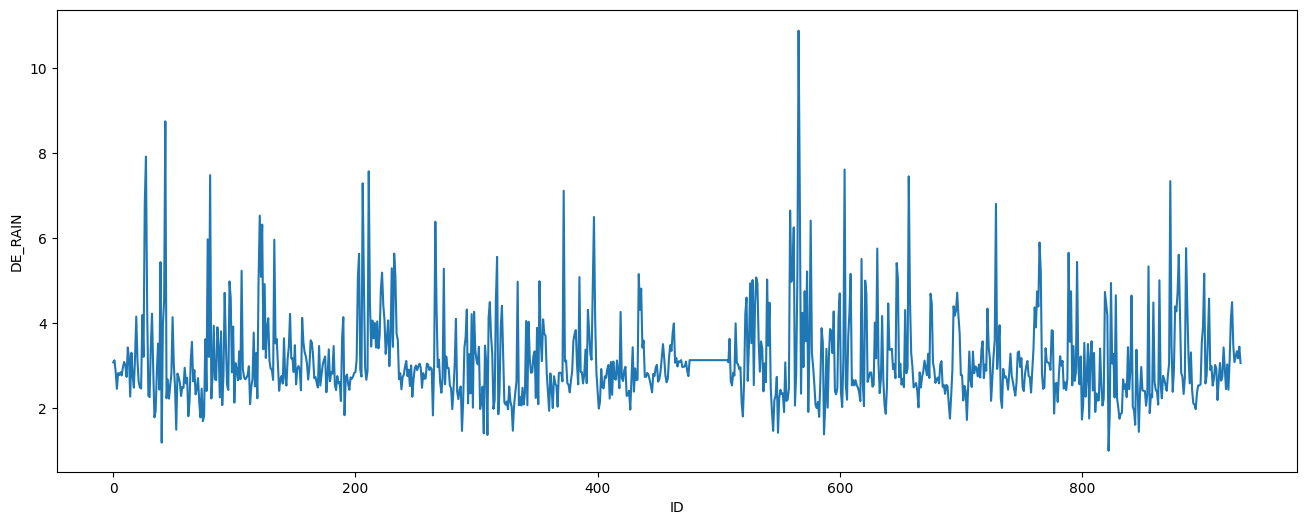

<Figure size 640x480 with 0 Axes>

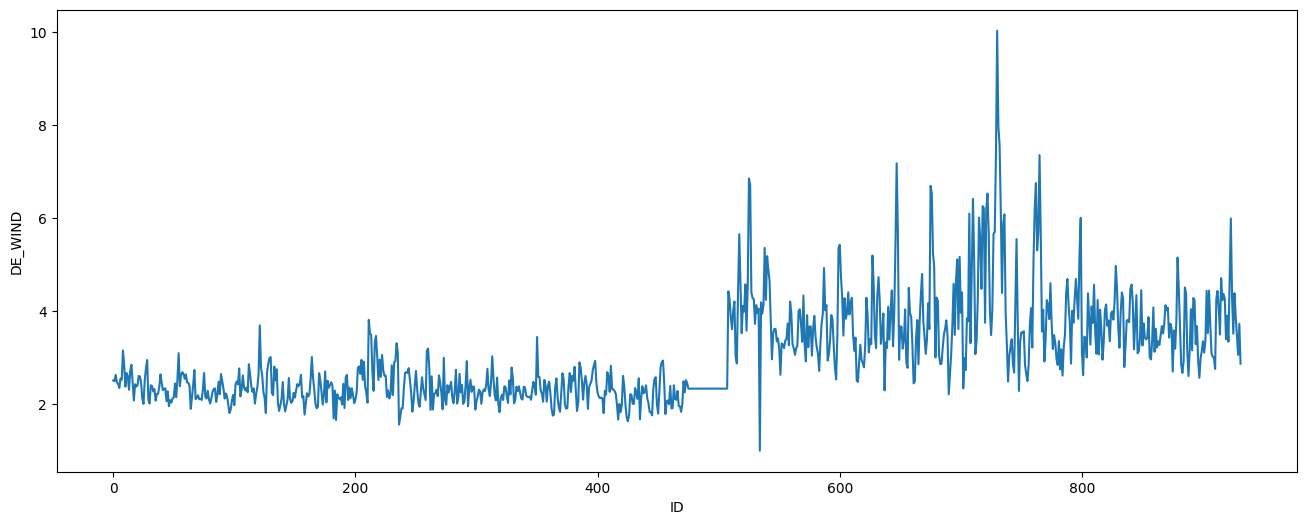

<Figure size 640x480 with 0 Axes>

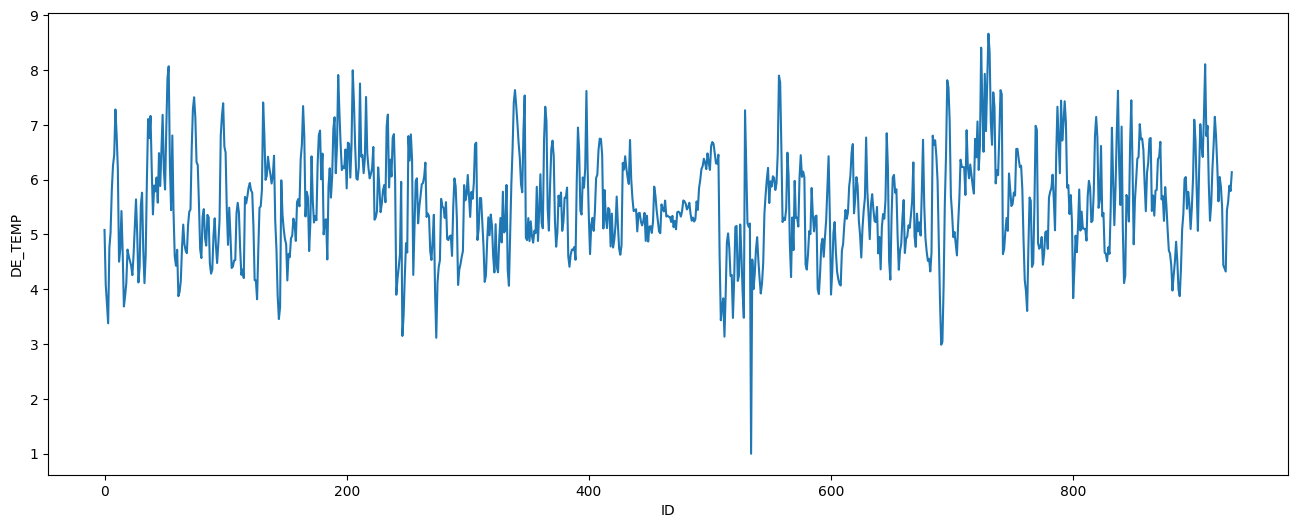

<Figure size 640x480 with 0 Axes>

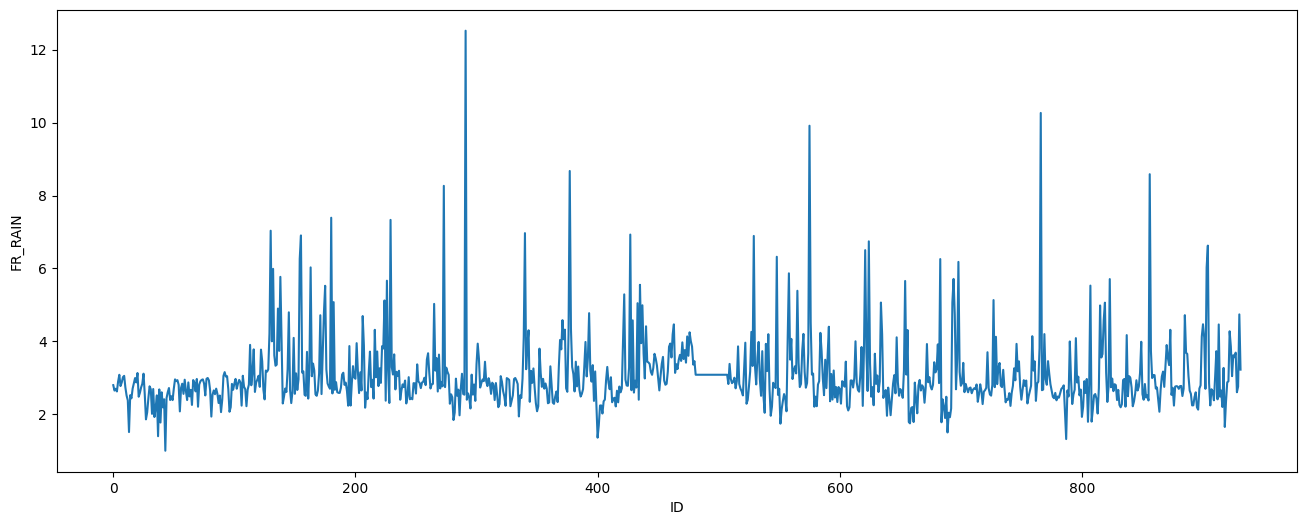

<Figure size 640x480 with 0 Axes>

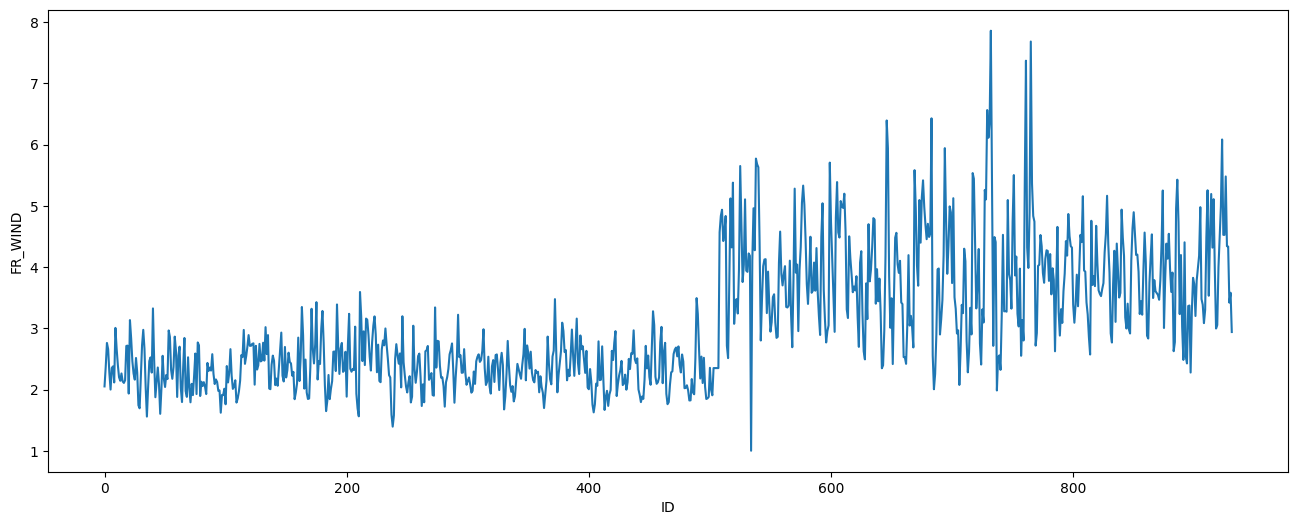

<Figure size 640x480 with 0 Axes>

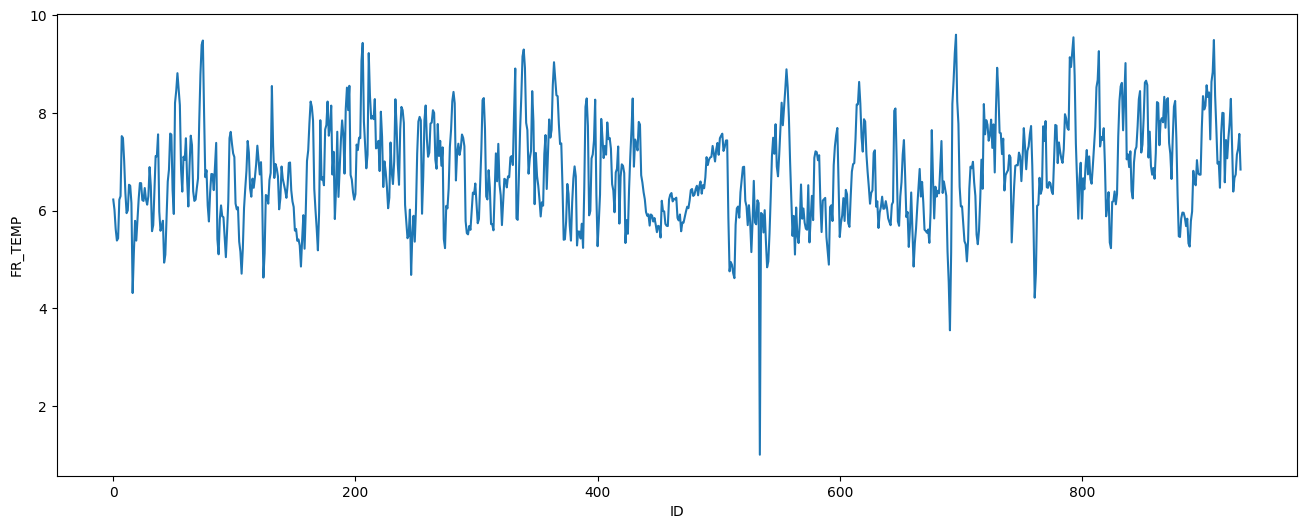

In [4]:
for w in weather_vars:
    plt.figure()
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.set_ylabel(w)
    X[w].plot()
    plt.show()

#### Plots

In [ ]:
de_wind = de[de['DE_WIND'].notna()]['DE_WIND'].append(weather_forecast['DE_WIND']).sort_index()
sns.lineplot(x=de_wind.index, y=de_wind)

In [ ]:
fr_wind = de[de['FR_WIND'].notna()]['FR_WIND'].append(weather_forecast['FR_WIND']).sort_index()
sns.lineplot(x=fr_wind.index, y=fr_wind)